# Fake News Detection - EDA and Preprocessing for LSTM
Dataset: WELFake (72,134 news articles)

QUICK NOTE: WHY LIBRARIES ARE IMPORTED MULTIPLE TIMES

You might notice that libraries like pandas are imported more than once in different sections.
This is not a mistake, it's done on purpose.

In Google Colab, running everything from start to finish can hit GPU usage limits
and cause the session to disconnect. To avoid this, each section is made to run independently.

By including the necessary imports in each section, you can run just that part
(like "Model Training") without needing to re-run earlier sections such as data cleaning.

As long as the required files are already in the directory, the section will work on its own.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

## STEP 1: LOAD AND BASIC EXPLORATION


### CRITICAL DATA CORRECTION: INVERTING DATASET LABELS ##
**The Problem:**
We discovered a major issue in the original WELFake dataset. The information
that came with the dataset said the labels were one way, but the actual
 data was the complete opposite.

   - What we thought:   1 = Real News, 0 = Fake News (mentioned in official documentation)
   - What it really was: 1 = FAKE News, 0 = REAL News

This meant that our first trained model and all of its results were wrong.
For example, when the model correctly identified a "Fake" article (label 1),
our reports called it "Real". This made our charts and metrics unusable
 for our final report.

 **The Fix:**
 This single line of code fixes the entire problem at the source. It "flips"
 every label in the dataset by subtracting the label from 1.

   - If the old label is 1 (Fake), the new label becomes 0 (because 1 - 1 = 0).
   - If the old label is 0 (Real), the new label becomes 1 (because 1 - 0 = 1).

**The Result:**
 After this code runs, the labels in our dataframe will finally be correct
 according to our project's goal:

   - Corrected Labels:   1 = REAL News, 0 = FAKE News
Every step that follows this—training, evaluation, charts, and reports—will
now be accurate and reliable.


In [ ]:
# Load the dataset
df = pd.read_csv('/content/WELFake_Dataset.csv')

# Now, 1 = REAL and 0 = FAKE.
df['label'] = 1 - df['label']

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check to make sure the label flipping worked
print(df[df['label'] == 1]['text'].str[:500].sample(3).values)
print(df[df['label'] == 0]['text'].str[:500].sample(3).values)

Dataset shape: (72134, 4)
Memory usage: 384.09 MB
['EDINBURGH (Reuters) - Pro-independence Scottish lawmakers have presented a motion in their devolved parliament urging international recognition of Catalonia s unilateral declaration of independence from Spain, putting pressure on Scotland s leader to endorse the movement. Scotland s pro-independence First Minister Nicola Sturgeon has criticized Madrid s handling of the crisis with its northern region but refrained from backing the declaration. The European Union, which she would like to see admi'
 'Five key states will hold Republican and Democratic primaries on Tuesday. The outcome could define the race for both parties.\n\nBut as voters prepare to head to the polls, controversy over a string of violent brawls continues to swirl around Donald Trump.\n\nAt a Trump rally in Ohio Sunday, Secret Service agents rushed to protect the Republican frontrunner after a protestor stormed the stage. And at other rallies throughout the weekend, Tr

## STEP 2: BASIC DATASET INFO

In [ ]:
print("\nColumn names and types:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
df.info()


Column names and types:
Unnamed: 0     int64
title         object
text          object
label          int64
dtype: object

First few rows:
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      0  
1     Did they post their votes for Hillary already?      0  
2   Now, most of the demonstrators gathered last ...      0  
3  A dozen politically active pastors came here f...      1  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      0  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries,

## STEP 3: MISSING VALUES ANALYSIS

The EDA revealed that 'title' has ~0.77% missing values and 'text' has a tiny ~0.05%.
This is a small enough percentage that we can likely fill them with empty strings
later on, rather than dropping several hundred rows, which would be a waste of good data.

            Missing Count  Missing Percentage
Unnamed: 0              0            0.000000
title                 558            0.773560
text                   39            0.054066
label                   0            0.000000


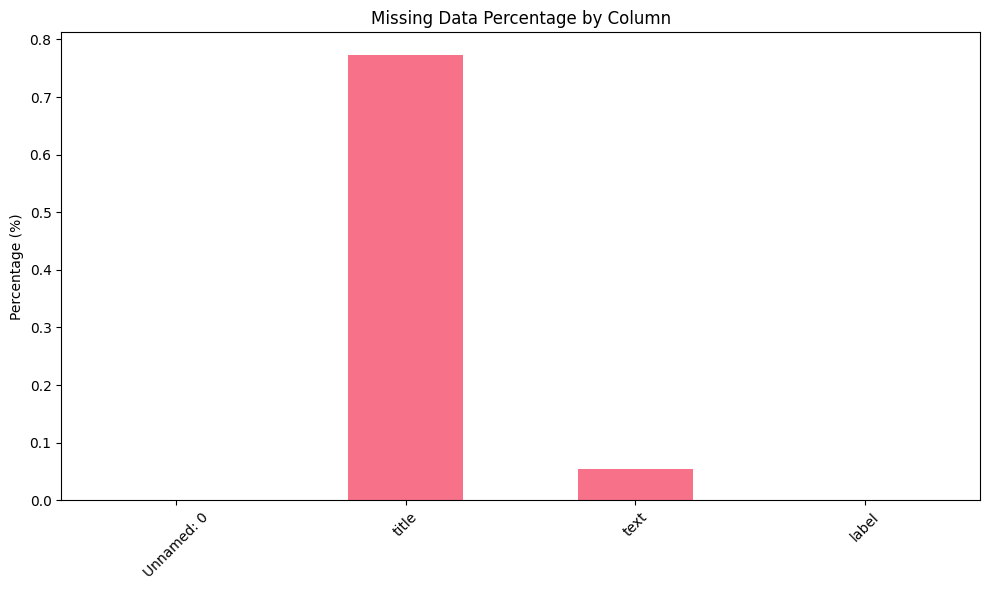

In [ ]:
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
print(missing_df)

# Visualize missing data
plt.figure(figsize=(10, 6))
missing_df['Missing Percentage'].plot(kind='bar')
plt.title('Missing Data Percentage by Column')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## STEP 4: TARGET VARIABLE ANALYSIS

Label distribution:
label
0    37106
1    35028
Name: count, dtype: int64

Label 0 (Fake): 37106 (51.4%)
Label 1 (Real): 35028 (48.6%)


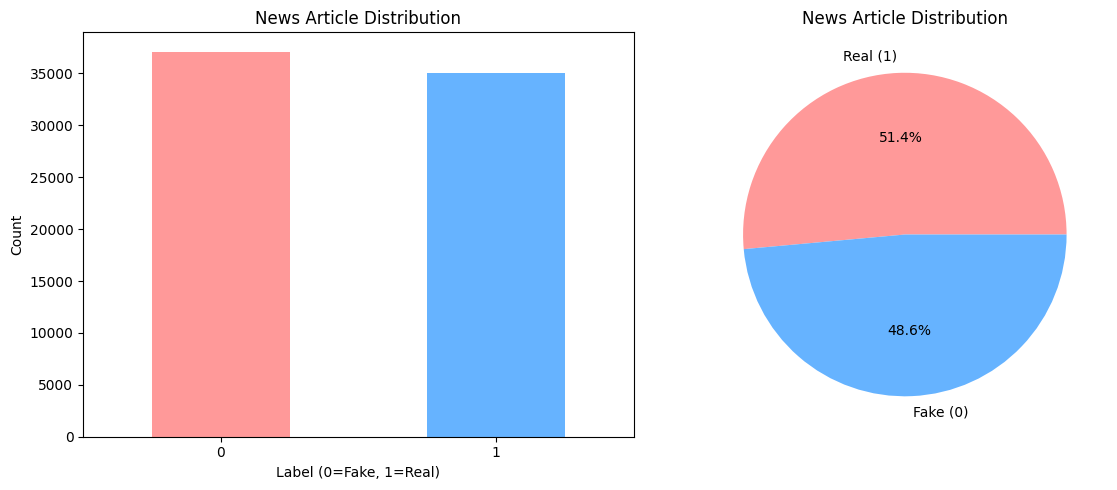

In [ ]:
label_counts = df['label'].value_counts()
print("Label distribution:")
print(label_counts)
print(f"\nLabel 0 (Fake): {label_counts[0]} ({label_counts[0]/len(df)*100:.1f}%)")
print(f"Label 1 (Real): {label_counts[1]} ({label_counts[1]/len(df)*100:.1f}%)")

# Visualize label distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
label_counts.plot(kind='bar', ax=ax1, color=['#ff9999', '#66b3ff'])
ax1.set_title('News Article Distribution')
ax1.set_xlabel('Label (0=Fake, 1=Real)')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# Pie chart
ax2.pie(label_counts.values, labels=['Real (1)', 'Fake (0)'], autopct='%1.1f%%',
        colors=['#ff9999', '#66b3ff'])
ax2.set_title('News Article Distribution')

plt.tight_layout()
plt.show()

## STEP 5: TEXT LENGTH ANALYSIS

The results are quite revealing:
Fake news titles are noticeably longer on average (85 chars vs. 69 for real).
Real news articles tend to be much longer.
This suggests that text length and word count could be useful features for the model.

Text Length Statistics:
       title_length    text_length  title_word_count  text_word_count
count  71576.000000   72095.000000      71576.000000     72095.000000
mean      77.141053    3270.155878         12.268218       540.843346
std       25.032921    3733.112756          4.133661       625.442464
min        1.000000       1.000000          1.000000         0.000000
25%       62.000000    1379.000000          9.000000       227.000000
50%       73.000000    2425.000000         12.000000       399.000000
75%       89.000000    4060.000000         14.000000       667.000000
max      456.000000  142961.000000         72.000000     24234.000000

Text Length by Label:

Fake News:
  Title length: 85.1 ± 30.0
  Text length: 3057.4 ± 4069.7
  Title words: 13.4 ± 4.8
  Text words: 506.1 ± 677.3

Real News:
  Title length: 68.8 ± 14.4
  Text length: 3495.3 ± 3325.5
  Title words: 11.0 ± 2.9
  Text words: 577.6 ± 563.1


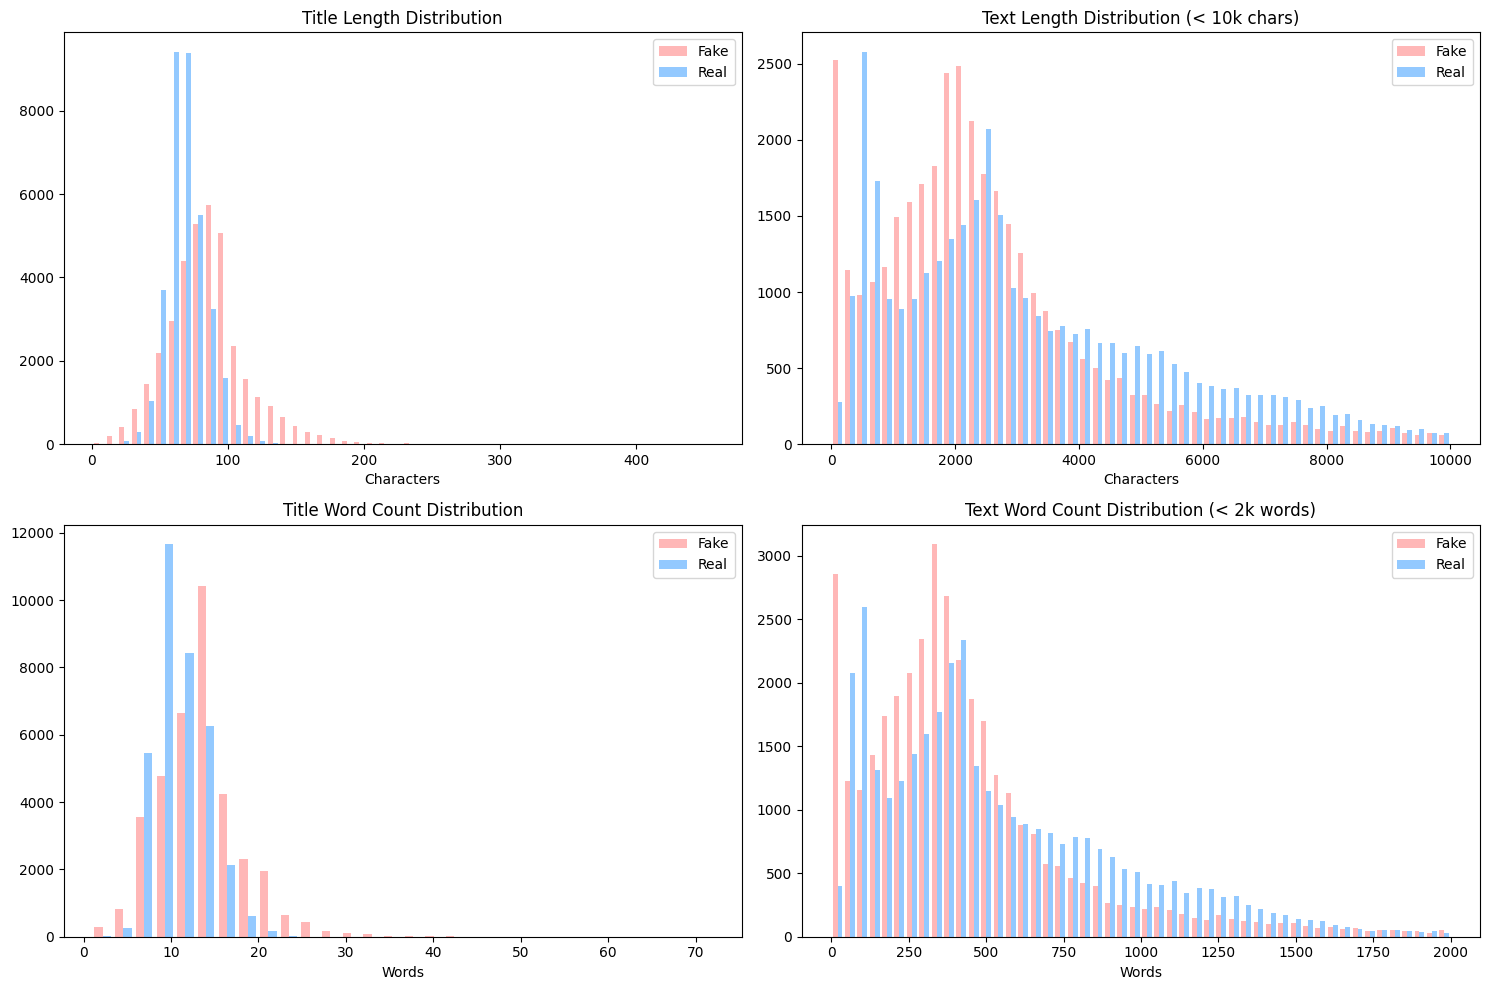

In [ ]:
# Calculate text lengths
df['title_length'] = df['title'].str.len()
df['text_length'] = df['text'].str.len()
df['title_word_count'] = df['title'].str.split().str.len()
df['text_word_count'] = df['text'].str.split().str.len()

# Basic statistics
print("Text Length Statistics:")
length_stats = df[['title_length', 'text_length', 'title_word_count', 'text_word_count']].describe()
print(length_stats)

# Text length by label
print("\nText Length by Label:")
for label in [0, 1]:
    label_name = "Fake" if label == 0 else "Real"
    subset = df[df['label'] == label]
    print(f"\n{label_name} News:")
    print(f"  Title length: {subset['title_length'].mean():.1f} ± {subset['title_length'].std():.1f}")
    print(f"  Text length: {subset['text_length'].mean():.1f} ± {subset['text_length'].std():.1f}")
    print(f"  Title words: {subset['title_word_count'].mean():.1f} ± {subset['title_word_count'].std():.1f}")
    print(f"  Text words: {subset['text_word_count'].mean():.1f} ± {subset['text_word_count'].std():.1f}")

# Visualize text lengths
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Title length distribution
axes[0,0].hist([df[df['label']==0]['title_length'], df[df['label']==1]['title_length']],
               bins=50, alpha=0.7, label=['Fake', 'Real'], color=['#ff9999', '#66b3ff'])
axes[0,0].set_title('Title Length Distribution')
axes[0,0].set_xlabel('Characters')
axes[0,0].legend()

# Text length distribution (capped for better visualization)
text_lengths_fake = df[df['label']==0]['text_length']
text_lengths_real = df[df['label']==1]['text_length']
axes[0,1].hist([text_lengths_fake[text_lengths_fake<10000],
                text_lengths_real[text_lengths_real<10000]],
               bins=50, alpha=0.7, label=['Fake', 'Real'], color=['#ff9999', '#66b3ff'])
axes[0,1].set_title('Text Length Distribution (< 10k chars)')
axes[0,1].set_xlabel('Characters')
axes[0,1].legend()

# Word count distributions
axes[1,0].hist([df[df['label']==0]['title_word_count'], df[df['label']==1]['title_word_count']],
               bins=30, alpha=0.7, label=['Fake', 'Real'], color=['#ff9999', '#66b3ff'])
axes[1,0].set_title('Title Word Count Distribution')
axes[1,0].set_xlabel('Words')
axes[1,0].legend()

word_counts_fake = df[df['label']==0]['text_word_count']
word_counts_real = df[df['label']==1]['text_word_count']
axes[1,1].hist([word_counts_fake[word_counts_fake<2000],
                word_counts_real[word_counts_real<2000]],
               bins=50, alpha=0.7, label=['Fake', 'Real'], color=['#ff9999', '#66b3ff'])
axes[1,1].set_title('Text Word Count Distribution (< 2k words)')
axes[1,1].set_xlabel('Words')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## STEP 6: TEXT QUALITY ANALYSIS

In [ ]:
# Function to analyze text quality
def analyze_text_quality(text):
    if pd.isna(text):
        return {'caps_ratio': 0, 'punct_ratio': 0, 'digit_ratio': 0}

    caps_count = sum(1 for c in text if c.isupper())
    punct_count = sum(1 for c in text if c in string.punctuation)
    digit_count = sum(1 for c in text if c.isdigit())
    total_chars = len(text)

    return {
        'caps_ratio': caps_count / total_chars if total_chars > 0 else 0,
        'punct_ratio': punct_count / total_chars if total_chars > 0 else 0,
        'digit_ratio': digit_count / total_chars if total_chars > 0 else 0
    }

# Analyze the entire dataset (all rows)
print(f"Analyzing text quality on all {len(df)} articles...")
quality_metrics = [analyze_text_quality(text) for text in df['text']]

quality_df = pd.DataFrame(quality_metrics)
df = df.reset_index(drop=True)
df['caps_ratio'] = quality_df['caps_ratio']
df['punct_ratio'] = quality_df['punct_ratio']
df['digit_ratio'] = quality_df['digit_ratio']

# Print metrics
print("\nText Quality Metrics by Label:")
for label in [0, 1]:
    label_name = "Fake" if label == 0 else "Real"
    subset = df[df['label'] == label]
    print(f"\n{label_name} News:")
    print(f"  Caps ratio: {subset['caps_ratio'].mean():.3f} ± {subset['caps_ratio'].std():.3f}")
    print(f"  Punctuation ratio: {subset['punct_ratio'].mean():.3f} ± {subset['punct_ratio'].std():.3f}")
    print(f"  Digit ratio: {subset['digit_ratio'].mean():.3f} ± {subset['digit_ratio'].std():.3f}")


Analyzing text quality on all 72134 articles...

Text Quality Metrics by Label:

Fake News:
  Caps ratio: 0.045 ± 0.045
  Punctuation ratio: 0.024 ± 0.015
  Digit ratio: 0.008 ± 0.012

Real News:
  Caps ratio: 0.038 ± 0.015
  Punctuation ratio: 0.023 ± 0.006
  Digit ratio: 0.006 ± 0.006


## STEP 7: WORD FREQUENCY ANALYSIS

In [ ]:
# Function to clean and tokenize text
def clean_text(text):
    if pd.isna(text):
        return []
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [word for word in words if len(word) > 2]
    return words

# Analyze word frequencies for a sample
print("Analyzing word frequencies on sample...")
fake_words = []
real_words = []

for idx, row in df.iterrows():
    title = row['title'] if pd.notna(row['title']) else ''
    text = row['text'] if pd.notna(row['text']) else ''
    words = clean_text(title + ' ' + text)
    if row['label'] == 0:
        fake_words.extend(words)
    else:
        real_words.extend(words)

# Most common words
fake_counter = Counter(fake_words)
real_counter = Counter(real_words)

print(f"\nMost common words in FAKE news (sample):")
for word, count in fake_counter.most_common(10):
    print(f"  {word}: {count}")

print(f"\nMost common words in REAL news (sample):")
for word, count in real_counter.most_common(10):
    print(f"  {word}: {count}")


Analyzing word frequencies on sample...

Most common words in FAKE news (sample):
  the: 1050123
  and: 450285
  that: 268058
  for: 176313
  with: 120893
  was: 113437
  this: 108399
  trump: 105530
  are: 99770
  have: 89432

Most common words in REAL news (sample):
  the: 1195190
  and: 466526
  that: 251938
  for: 197884
  said: 184625
  with: 135917
  was: 132919
  his: 105723
  has: 98161
  from: 92807


## STEP 8: DATA QUALITY ISSUES

In [ ]:

# Check for empty or very short texts
empty_titles = df['title'].isna().sum()
empty_texts = df['text'].isna().sum()
very_short_titles = (df['title_length'] < 10).sum()
very_short_texts = (df['text_length'] < 50).sum()

print(f"Empty titles: {empty_titles}")
print(f"Empty texts: {empty_texts}")
print(f"Very short titles (< 10 chars): {very_short_titles}")
print(f"Very short texts (< 50 chars): {very_short_texts}")

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")
print(f"Duplicate titles: {df['title'].duplicated().sum()}")
print(f"Duplicate texts: {df['text'].duplicated().sum()}")

# Show some problematic entries
print(f"\nSample of very short titles:")
short_titles = df[df['title_length'] < 10]['title'].head()
for i, title in enumerate(short_titles):
    print(f"  {i+1}: '{title}'")


Empty titles: 558
Empty texts: 39
Very short titles (< 10 chars): 26
Very short texts (< 50 chars): 1088

Duplicate rows: 0
Duplicate titles: 9786
Duplicate texts: 9415

Sample of very short titles:
  1: 'Wow!'
  2: 'Tweetwave'
  3: 'Wikileaks'
  4: 'EPIC'
  5: 'Rick Rule'


# Text Preprocessing Pipeline for LSTM Model
Based on EDA findings from WELFake dataset

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


# Download NLTK data (only needs to be done once)
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('tokenizers/punkt/english.pickle')
except LookupError:
    nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## STEP 1: INITIAL CLEANING

In [ ]:
print(f"Original dataset shape: {df.shape}")

# Handle missing values based on EDA findings
print(f"Missing titles: {df['title'].isna().sum()}")
print(f"Missing texts: {df['text'].isna().sum()}")

# Fill missing titles and texts with empty strings
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

# Remove rows where both title and text are empty
df = df[~((df['title'] == '') & (df['text'] == ''))]
print(f"After removing empty rows: {df.shape}")

# Remove duplicate rows (keep first occurrence)
df = df.drop_duplicates(subset=['title', 'text'], keep='first')
print(f"After removing duplicates: {df.shape}")

Original dataset shape: (72134, 4)
Missing titles: 558
Missing texts: 39
After removing empty rows: (72134, 4)
After removing duplicates: (63678, 4)


## STEP 2: TEXT CLEANING FUNCTIONS

In [ ]:
nltk.download('punkt_tab')
def clean_text(text):
    if pd.isna(text) or text == '':
        return ''

    # Ensure text is a string and convert to lowercase
    text = str(text).lower()

    # Expand contractions
    contractions = {
        "won't": "will not", "can't": "cannot", "n't": " not", "'re": " are",
        "'ve": " have", "'ll": " will", "'d": " would", "'m": " am",
        "let's": "let us", "don't": "do not", "doesn't": "does not",
        "didn't": "did not", "isn't": "is not", "wasn't": "was not",
        "weren't": "were not", "haven't": "have not", "hasn't": "has not",
        "hadn't": "had not", "wouldn't": "would not",
        "shouldn't": "should not", "couldn't": "could not",
        "mustn't": "must not"
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)

    # Remove URLs, email addresses, and HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', '', text)

    # Remove source artifacts like "21st Century Wire" or "via Reuters"
    text = re.sub(r'(\d+)(st|nd|rd|th)\s*century\s*wire', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s*via\s+[\w\s.-]+', '', text)
    text = re.sub(r'pic.twitter.com/\w+', '', text)

    # Tokenize the text, which will separate words from punctuation
    tokens = word_tokenize(text)

    # Initialize lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Add specific words to the stop word list that might introduce bias
    additional_stopwords = {
        'reuters', 'breitbart', 'cnn', 'fox', 'bbc', 'nbc', 'abc', 'cbs',
        'associated', 'press', 'ap', 'bloomberg', 'wall', 'street', 'journal',
        'new', 'york', 'times', 'washington', 'post', 'guardian',
        'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
        'january', 'february', 'march', 'april', 'may', 'june', 'july',
        'august', 'september', 'october', 'november', 'december',
        'said', 'according', 'reported', 'also', 'u', 'image', 'images', 'video', 'videos',
        'file', 'files', 'tag', 'tags', 'loading', 'download', 'nyp', 'rasmussen', 'vice',
        'pic', 'via', 'twitter', 'news'
    }
    stop_words.update(additional_stopwords)

    cleaned_tokens = []
    for token in tokens:
        # Keep only alphabetic tokens
        if token.isalpha():
            lemma = lemmatizer.lemmatize(token)
            # Check length and stopwords AFTER lemmatizing
            if len(lemma) > 1 and lemma not in stop_words:
                cleaned_tokens.append(lemma)

    # Join tokens back into a single string.
    # The result will be a clean string of words, e.g., "article content"
    # This is the standard format for feeding into tokenizers.
    return " ".join(cleaned_tokens)

def combine_title_text(title, text, title_weight=2):
    """
    Combine title and text with higher weight for title
    Title is usually more informative for fake news detection
    """
    clean_title = clean_text(title)
    cleaned_text_content = clean_text(text)

    # Repeat title to give it more weight
    weighted_title = ' '.join([clean_title] * title_weight)

    # Combine
    combined = weighted_title + ' ' + cleaned_text_content
    return combined.strip()

# Test the cleaning functions
print("Testing text cleaning functions...")
sample_text = "WON'T believe this FAKE NEWS!!! Visit http://fake-news.com for more info! Email: fake@news.com"
print(f"Original: {sample_text}")
print(f"Cleaned: {clean_text(sample_text)}")

sample_title = "BREAKING: Obama's Secret Plan!"
sample_content = "This is unbelievable news that you won't believe..."
print(f"\nOriginal title: {sample_title}")
print(f"Original text: {sample_content}")
print(f"Combined: {combine_title_text(sample_title, sample_content)}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Testing text cleaning functions...
Original: WON'T believe this FAKE NEWS!!! Visit http://fake-news.com for more info! Email: fake@news.com
Cleaned: believe fake visit info email

Original title: BREAKING: Obama's Secret Plan!
Original text: This is unbelievable news that you won't believe...
Combined: breaking obama secret plan breaking obama secret plan unbelievable believe


## STEP 3: APPLY PREPROCESSING

Cleaning and combining text... (this may take a few minutes)
Dataset size before word count filtering: (63678, 6)
Removed 265 articles with less than 10 words
Final dataset size: (63413, 6)

Splitting data into train, validation, and test sets...
Training set: 44389 samples
Validation set: 9512 samples
Test set: 9512 samples

Text length statistics after cleaning:
Mean word count: 300.7
Median word count: 227.0
Max word count: 18076
Min word count: 10


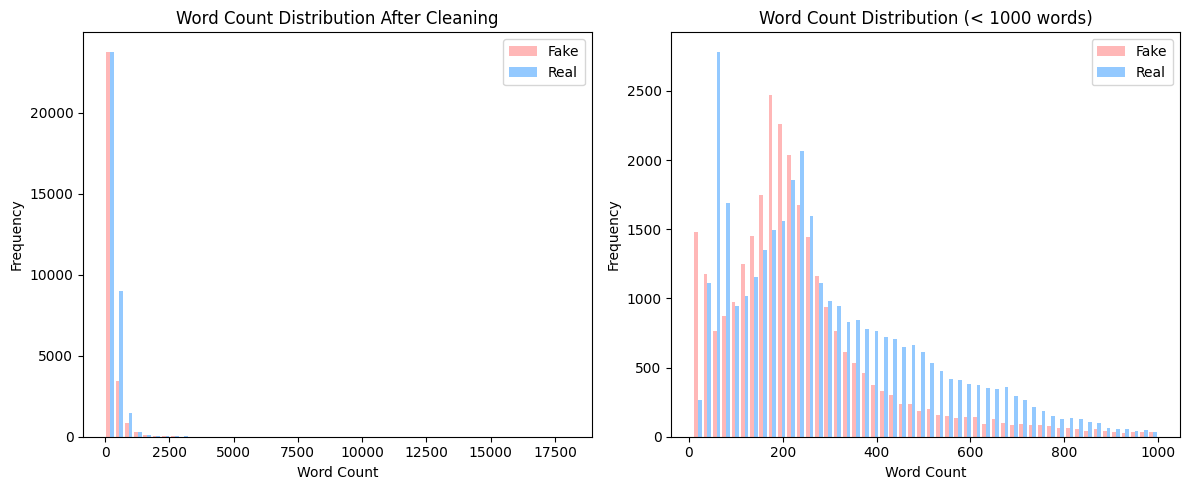

In [ ]:
# Apply text cleaning and combination
print("Cleaning and combining text... (this may take a few minutes)")
df['cleaned_text'] = df.apply(lambda row: combine_title_text(row['title'], row['text']), axis=1)

# Calculate word counts for filtering
df['word_count'] = df['cleaned_text'].str.split().str.len()
print(f"Dataset size before word count filtering: {df.shape}")

# Apply word count filtering
initial_count = len(df)
df = df[df['word_count'] >= 10]
print(f"Removed {initial_count - len(df)} articles with less than 10 words")
print(f"Final dataset size: {df.shape}")

print("\nSplitting data into train, validation, and test sets...")

# Define features (X) and labels (y) from your dataframe
X = df['cleaned_text']
y = df['label']
# Store original texts before splitting for feature extraction
original_texts = df['title'].fillna('') + ' ' + df['text'].fillna('')

# Create the initial split (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp, train_orig, temp_orig = train_test_split(
    X, y, original_texts,
    test_size=0.30,      # Split off 30% for validation and testing
    random_state=42,
    stratify=y
)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test, val_orig, test_orig = train_test_split(
    X_temp, y_temp, temp_orig,
    test_size=0.50,      # Split the 30% in half (15% validation, 15% test)
    random_state=42,
    stratify=y_temp
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Check text length distribution after cleaning
print(f"\nText length statistics after cleaning:")
print(f"Mean word count: {df['word_count'].mean():.1f}")
print(f"Median word count: {df['word_count'].median():.1f}")
print(f"Max word count: {df['word_count'].max()}")
print(f"Min word count: {df['word_count'].min()}")

# Visualize cleaned text lengths
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist([df[df['label']==0]['word_count'], df[df['label']==1]['word_count']],
         bins=50, alpha=0.7, label=['Fake', 'Real'], color=['#ff9999', '#66b3ff'])
plt.title('Word Count Distribution After Cleaning')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
# Focus on articles with less than 1000 words for better visualization
word_counts_fake = df[df['label']==0]['word_count']
word_counts_real = df[df['label']==1]['word_count']
plt.hist([word_counts_fake[word_counts_fake<1000],
          word_counts_real[word_counts_real<1000]],
         bins=50, alpha=0.7, label=['Fake', 'Real'], color=['#ff9999', '#66b3ff'])
plt.title('Word Count Distribution (< 1000 words)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


##STEP 4: FEATURE EXTRACTION

In [ ]:
def extract_content_features(original_texts):
    features = []

    for text in original_texts:
        if pd.isna(text) or text == '':
            features.append([0, 0, 0, 0, 0, 0])
            continue

        words = text.split()
        if len(words) == 0:
            features.append([0, 0, 0, 0, 0, 0])
            continue

        # Content-based features
        exclamation_ratio = text.count('!') / len(text)
        question_ratio = text.count('?') / len(text)
        caps_ratio = sum(1 for c in text if c.isupper()) / len(text)
        avg_word_length = sum(len(word) for word in words) / len(words)
        sentence_count = len(re.split(r'[.!?]+', text))
        avg_sentence_length = len(words) / sentence_count if sentence_count > 0 else 0

        features.append([exclamation_ratio, question_ratio, caps_ratio,
                        avg_word_length, sentence_count, avg_sentence_length])

    return np.array(features)

# Use original text for feature extraction
# Get original texts that correspond to our splits
print("Extracting content features from properly split data...")

X_train_features = extract_content_features(train_orig)
X_val_features = extract_content_features(val_orig)
X_test_features = extract_content_features(test_orig)

print(f"Content features shape: {X_train_features.shape}")

print("Saving content feature arrays...")
np.save('X_train_features.npy', X_train_features)
np.save('X_val_features.npy', X_val_features)
np.save('X_test_features.npy', X_test_features)
print("✓ Feature arrays saved.")

Extracting content features from properly split data...
Content features shape: (44389, 6)
Saving content feature arrays...
✓ Feature arrays saved.


## STEP 5: TOKENIZATION SETUP

In [ ]:


# To prevent data leakage, the tokenizer will be fit only on the training data.
print("Vocabulary analysis will be performed on training data only")

# Set tokenization parameters
VOCAB_SIZE = 20000  # Based on EDA, this should cover most important words
MAX_SEQUENCE_LENGTH = 500  # Based on text length distribution
OOV_TOKEN = "<OOV>"  # Out of vocabulary token

print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Maximum sequence length: {MAX_SEQUENCE_LENGTH}")

# Define biased words to exclude from vocabulary
BIASED_WORDS = {
    'reuters', 'breitbart', 'cnn', 'fox', 'bbc', 'nbc', 'abc', 'cbs',
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
    'washington', 'berlin', 'york', 'london', 'paris', 'moscow', 'beijing',
    'said', 'times', 'news', 'reported', 'according'
}

# Custom tokenizer class that filters biased words
class BiasAwareTokenizer(Tokenizer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.biased_words = BIASED_WORDS

    def fit_on_texts(self, texts):
        # First, do normal fitting
        super().fit_on_texts(texts)

        # Then remove biased words from word_index
        words_to_remove = []
        for word in self.word_index:
            if word.lower() in self.biased_words:
                words_to_remove.append(word)

        # Remove biased words from word_index and word_counts
        for word in words_to_remove:
            del self.word_index[word]
            if word in self.word_counts:
                del self.word_counts[word]

        # Rebuild word_index with consecutive indices
        sorted_words = sorted(self.word_index.items(), key=lambda x: x[1])
        self.word_index = {word: i+1 for i, (word, _) in enumerate(sorted_words)}

        print(f"Removed {len(words_to_remove)} biased words from vocabulary")

# Replace the tokenizer initialization
tokenizer = BiasAwareTokenizer(
    num_words=VOCAB_SIZE,
    oov_token=OOV_TOKEN,
    lower=True,
    split=' ',
    char_level=False
)

# Determine vocabulary size from training data only
print("Analyzing vocabulary from training data only...")
all_train_words = []
# Use sampling to avoid memory issues
train_sample_size = min(10000, len(X_train))
train_sample = X_train.sample(n=train_sample_size, random_state=42)
for text in train_sample:
    all_train_words.extend(text.split())

unique_train_words = len(set(all_train_words))
print(f"Unique words in training sample: {unique_train_words}")

# Fit tokenizer ONLY on the training data to prevent data leakage
print("Fitting tokenizer on training texts...")
tokenizer.fit_on_texts(X_train) # Fit ONLY on X_train

# Get vocabulary statistics
word_index = tokenizer.word_index
print(f"Total words in vocabulary: {len(word_index)}")
print(f"Using top {VOCAB_SIZE} words")

# Show most common words
print(f"\nTop 20 most common words:")
sorted_word_freq = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)
for i, (word, freq) in enumerate(sorted_word_freq[:20]):
    print(f"  {i+1:2d}. {word}: {freq}")



Vocabulary analysis will be performed on training data only
Vocabulary size: 20000
Maximum sequence length: 500
Analyzing vocabulary from training data only...
Unique words in training sample: 80251
Fitting tokenizer on training texts...
Removed 5 biased words from vocabulary
Total words in vocabulary: 162850
Using top 20000 words

Top 20 most common words:
   1. trump: 157758
   2. wa: 152847
   3. ha: 112771
   4. state: 71399
   5. would: 68275
   6. president: 57110
   7. people: 56343
   8. one: 56274
   9. time: 50598
  10. year: 47860
  11. clinton: 47857
  12. republican: 42475
  13. say: 37164
  14. like: 35790
  15. obama: 34470
  16. government: 33527
  17. american: 32892
  18. could: 32631
  19. house: 32216
  20. country: 30309


## STEP 6: SEQUENCE CREATION

In [ ]:
# Convert each text split to sequences using the fitted tokenizer
print("Converting texts to sequences...")
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to uniform length
print(f"Padding sequences to length {MAX_SEQUENCE_LENGTH}...")
X_train_padded = pad_sequences(
    X_train_sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding='post',
    truncating='post'
)

X_val_padded = pad_sequences(
    X_val_sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding='post',
    truncating='post'
)

X_test_padded = pad_sequences(
    X_test_sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding='post',
    truncating='post'
)

print(f"Padded training sequences shape: {X_train_padded.shape}")
print(f"Padded validation sequences shape: {X_val_padded.shape}")
print(f"Padded test sequences shape: {X_test_padded.shape}")

Converting texts to sequences...
Padding sequences to length 500...
Padded training sequences shape: (44389, 500)
Padded validation sequences shape: (9512, 500)
Padded test sequences shape: (9512, 500)


## STEP 7: SAVE PREPROCESSING ARTIFACTS

In [ ]:
# Save preprocessed data
# Use the PADDED arrays for X, as this is what the model needs
np.save('X_train_padded.npy', X_train_padded)
np.save('X_val_padded.npy', X_val_padded)
np.save('X_test_padded.npy', X_test_padded)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)
# Save tokenizer for later use
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Saved preprocessing artifacts:")
print("  - X_train.npy, X_val.npy, X_test.npy")
print("  - y_train.npy, y_val.npy, y_test.npy")
print("  - tokenizer.pkl")


print("PREPROCESSING SUMMARY")
print(f"""
DATASET PREPROCESSING COMPLETE!

Original dataset: 72,134 articles
After cleaning: {len(df)} articles
Final splits:
  - Training: {len(X_train)} samples
  - Validation: {len(X_val)} samples
  - Testing: {len(X_test)} samples

Text Processing:
  - Combined titles and text (title weighted 2x)
  - Cleaned URLs, emails, HTML tags, contractions
  - Removed duplicates and very short articles
  - Tokenized with vocabulary size: {VOCAB_SIZE}
  - Padded sequences to length: {MAX_SEQUENCE_LENGTH}

Label Distribution (balanced):
  - Fake news: ~48.6%
  - Real news: ~51.4%
""")

Saved preprocessing artifacts:
  - X_train.npy, X_val.npy, X_test.npy
  - y_train.npy, y_val.npy, y_test.npy
  - tokenizer.pkl
PREPROCESSING SUMMARY

DATASET PREPROCESSING COMPLETE!

Original dataset: 72,134 articles
After cleaning: 63413 articles
Final splits:
  - Training: 44389 samples
  - Validation: 9512 samples
  - Testing: 9512 samples

Text Processing:
  - Combined titles and text (title weighted 2x)
  - Cleaned URLs, emails, HTML tags, contractions
  - Removed duplicates and very short articles
  - Tokenized with vocabulary size: 20000
  - Padded sequences to length: 500

Label Distribution (balanced):
  - Fake news: ~48.6%
  - Real news: ~51.4%



#  LSTM Fake News Detection Model - Architecture & Training

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [ ]:
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## STEP 1: LOAD PREPROCESSED DATA


In [ ]:
# Load the preprocessed data
X_train_padded = np.load('X_train_padded.npy')
X_val_padded = np.load('X_val_padded.npy')
X_test_padded = np.load('X_test_padded.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')


In [ ]:
# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")

# Verify label distribution
print(f"\nLabel Distribution:")
print(f"Train - Fake: {(y_train == 0).sum()}, Real: {(y_train == 1).sum()}")
print(f"Val   - Fake: {(y_val == 0).sum()}, Real: {(y_val == 1).sum()}")
print(f"Test  - Fake: {(y_test == 0).sum()}, Real: {(y_test == 1).sum()}")

Training data shape: (44389,)
Validation data shape: (9512,)
Test data shape: (9512,)
Vocabulary size: 162850

Label Distribution:
Train - Fake: 20037, Real: 24352
Val   - Fake: 4293, Real: 5219
Test  - Fake: 4294, Real: 5218


## STEP 2: Bayesian optimization

In [ ]:
# Install required packages for Bayesian optimization
!pip install scikit-optimize

import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.callbacks import DeltaXStopper
import joblib
import json
from datetime import datetime

# Import the Input layer and Concatenate layer
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model

# Fixed parameters (to keep training time reasonable)
VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 500

# Define the hyperparameter search space
search_space = [
    Integer(64, 256, name='embedding_dim'),           # Embedding dimension
    Integer(64, 256, name='lstm_units'),              # LSTM units
    Real(0.3, 0.5, name='dropout_rate'),              # Dropout rate
    Real(0.001, 0.005, name='learning_rate', prior='log-uniform'),  # Learning rate
    Integer(64, 128, name='batch_size'),              # Batch size
    Integer(16, 64, name='dense_units'),              # Dense layer units
    Categorical(['adam', 'rmsprop'], name='optimizer'), # Optimizer
    Integer(1, 3, name='num_dense_layers'),           # Number of dense layers
    Real(0.001, 0.01, name='l2_reg', prior='log-uniform'), # L2 regularization
]

# Store results for analysis
optimization_results = []

# Best score tracker
best_score = -np.inf
best_params = None

class AttentionSum(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionSum, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.reduce_sum(inputs, axis=1)

    def compute_output_shape(self, input_shape):
        # input_shape = (batch_size, sequence_length, features)
        # Output will be (batch_size, features)
        return (input_shape[0], input_shape[2])


@use_named_args(search_space)
def objective(**params):
    """
    Objective function for Bayesian optimization
    Returns negative validation accuracy (since we minimize)
    """
    global best_score, best_params


    print(f"TRIAL {len(optimization_results) + 1}")

    print(f"Testing parameters: {params}")
    # Convert numpy types to Python native types
    params = {k: v.item() if hasattr(v, 'item') else v for k, v in params.items()}

    try:
        # Convert numpy integers to Python integers
        embedding_dim = int(params['embedding_dim'])
        lstm_units = int(params['lstm_units'])
        dropout_rate = float(params['dropout_rate'])
        learning_rate = float(params['learning_rate'])
        batch_size = int(params['batch_size'])
        dense_units = int(params['dense_units'])
        optimizer_name = params['optimizer']
        num_dense_layers = int(params['num_dense_layers'])
        l2_reg = float(params['l2_reg'])

        # Clear any existing models from memory
        tf.keras.backend.clear_session()

        # Extract hyperparameters
        embedding_dim = params['embedding_dim']
        lstm_units = params['lstm_units']
        dropout_rate = params['dropout_rate']
        learning_rate = params['learning_rate']
        batch_size = params['batch_size']
        dense_units = params['dense_units']
        optimizer_name = params['optimizer']
        num_dense_layers = params['num_dense_layers']
        l2_reg = params['l2_reg']

        # Build model with current hyperparameters
        text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')

        # Embedding layer
        embedded = Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=embedding_dim,
            input_length=MAX_SEQUENCE_LENGTH,
            name='embedding_layer'
        )(text_input)

        # CuDNN-optimized Bidirectional LSTM
        lstm_out = Bidirectional(
            LSTM(
                lstm_units,
                return_sequences=True,
                name='lstm_layer'
            ),
            name='bidirectional_lstm'
        )(embedded)

        # Dropout after LSTM
        lstm_out = Dropout(dropout_rate, name='lstm_dropout')(lstm_out)

        # Attention mechanism
        attention_weights = Dense(1, activation='tanh', name='attention_dense')(lstm_out)
        attention_weights = tf.keras.layers.Flatten(name='attention_flatten')(attention_weights)
        attention_weights = tf.keras.layers.Activation('softmax', name='attention_softmax')(attention_weights)
        attention_weights = tf.keras.layers.RepeatVector(lstm_units * 2, name='attention_repeat')(attention_weights)
        attention_weights = tf.keras.layers.Permute([2, 1], name='attention_permute')(attention_weights)

        # Apply attention
        attended_lstm = tf.keras.layers.Multiply(name='attention_multiply')([lstm_out, attention_weights])
        lstm_representation = AttentionSum(name='attention_sum')(attended_lstm)

        # Content features input
        content_input = Input(shape=(6,), name='content_features')
        content_dense = Dense(32, activation='relu', name='content_dense')(content_input)

        # Combine features
        combined = Concatenate(name='feature_concatenate')([lstm_representation, content_dense])

        # Variable number of dense layers
        x = combined
        for i in range(num_dense_layers):
            x = Dense(dense_units, activation='relu',
                     kernel_regularizer=l2(l2_reg),
                     name=f'dense_{i+1}')(x)
            x = Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
            # Reduce units in subsequent layers
            dense_units = max(16, dense_units // 2)

        # Output layer
        output = Dense(1, activation='sigmoid', name='output_layer')(x)

        # Create and compile model
        model = Model(inputs=[text_input, content_input], outputs=output)

        # Choose optimizer
        if optimizer_name == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Callbacks for this trial
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=0
        )

        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=0.00001,
            verbose=0
        )

        # Train model
        history = model.fit(
            [X_train_padded, X_train_features], y_train,
            batch_size=batch_size,
            epochs=6,
            validation_data=([X_val_padded, X_val_features], y_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )

        # Get validation accuracy
        val_accuracy = max(history.history['val_accuracy'])
        val_loss = min(history.history['val_loss'])

        # Store results
        result = {
            'trial': len(optimization_results) + 1,
            'params': params.copy(),
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'epochs_trained': len(history.history['val_accuracy']),
            'timestamp': datetime.now().isoformat()
        }
        optimization_results.append(result)

        # Update best score
        if val_accuracy > best_score:
            best_score = val_accuracy
            best_params = params.copy()
            # Save best model
            model.save('best_bayesian_model.h5')
            print(f"NEW BEST SCORE: {val_accuracy:.4f}")

        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Epochs trained: {len(history.history['val_accuracy'])}")

        # Clean up
        del model
        tf.keras.backend.clear_session()

        # Return negative accuracy (since we minimize)
        return -val_accuracy

    except Exception as e:
        print(f"Error in trial: {e}")
        return 0  # Return poor score for failed trials

# Bayesian optimization callback to save progress
def save_progress(result):
    """Save optimization progress after each iteration"""
    # Save results to file
    with open('bayesian_optimization_results.json', 'w') as f:
        json.dump(optimization_results, f, indent=2)

    # Save sklearn optimization result
    joblib.dump(result, 'bayesian_optimization_state.pkl')

    print(f"Progress saved. Best score so far: {-result.fun:.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.8 MB/s eta 0:00:00


## STEP 3: RUN BAYESIAN OPTIMIZATION

In [ ]:
print("Starting Bayesian Optimization for LSTM Hyperparameters")
print(f"Search space: {len(search_space)} hyperparameters")
print(f"Estimated time: ~2-3 hours on GPU")
print(f"Maximum trials: 20")

# Run Bayesian optimization
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=20,              # Number of trials
    n_initial_points=5,      # Random exploration first
    random_state=42,
    callback=[save_progress, DeltaXStopper(delta=0.001)],  # Early stopping
    verbose=False
)


print("BAYESIAN OPTIMIZATION COMPLETED!")


# Extract best hyperparameters
best_hyperparams = {
    'embedding_dim': result.x[0],
    'lstm_units': result.x[1],
    'dropout_rate': result.x[2],
    'learning_rate': result.x[3],
    'batch_size': result.x[4],
    'dense_units': result.x[5],
    'optimizer': result.x[6],
    'num_dense_layers': result.x[7],
    'l2_reg': result.x[8]
}

print(f"Best validation accuracy: {-result.fun:.4f}")
print(f"Best hyperparameters: {best_hyperparams}")

# Save final results
final_results = {
    'best_score': -result.fun,
    'best_params': best_hyperparams,
    'total_trials': len(optimization_results),
    'optimization_history': optimization_results
}
# Function to convert numpy types to Python native types
def convert_numpy_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Convert numpy types in final results
final_results = convert_numpy_types(final_results)

with open('final_bayesian_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

Starting Bayesian Optimization for LSTM Hyperparameters
Search space: 9 hyperparameters
Estimated time: ~2-3 hours on GPU
Maximum trials: 20
TRIAL 1
Testing parameters: {'embedding_dim': np.int64(217), 'lstm_units': np.int64(99), 'dropout_rate': 0.4559382000545539, 'learning_rate': 0.0026132463801565114, 'batch_size': np.int64(93), 'dense_units': np.int64(21), 'optimizer': 'adam', 'num_dense_layers': np.int64(2), 'l2_reg': 0.001389526449426104}


NEW BEST SCORE: 0.9285
Validation Accuracy: 0.9285
Validation Loss: 0.2061
Epochs trained: 6
Progress saved. Best score so far: 0.9285
TRIAL 2
Testing parameters: {'embedding_dim': np.int64(189), 'lstm_units': np.int64(75), 'dropout_rate': 0.444399754453365, 'learning_rate': 0.004529186363731317, 'batch_size': np.int64(64), 'dense_units': np.int64(64), 'optimizer': 'rmsprop', 'num_dense_layers': np.int64(2), 'l2_reg': 0.0010164038588691214}


NEW BEST SCORE: 0.9291
Validation Accuracy: 0.9291
Validation Loss: 0.2108
Epochs trained: 5
Progress saved. Best score so far: 0.9291
TRIAL 3
Testing parameters: {'embedding_dim': np.int64(68), 'lstm_units': np.int64(165), 'dropout_rate': 0.37997219434305113, 'learning_rate': 0.0010779978602778416, 'batch_size': np.int64(126), 'dense_units': np.int64(27), 'optimizer': 'adam', 'num_dense_layers': np.int64(2), 'l2_reg': 0.002412470387944658}


NEW BEST SCORE: 0.9303
Validation Accuracy: 0.9303
Validation Loss: 0.2310
Epochs trained: 6
Progress saved. Best score so far: 0.9303
TRIAL 4
Testing parameters: {'embedding_dim': np.int64(253), 'lstm_units': np.int64(154), 'dropout_rate': 0.47198808134726417, 'learning_rate': 0.002988921872793785, 'batch_size': np.int64(93), 'dense_units': np.int64(17), 'optimizer': 'rmsprop', 'num_dense_layers': np.int64(2), 'l2_reg': 0.002428938409410681}
Validation Accuracy: 0.8705
Validation Loss: 0.3434
Epochs trained: 6
Progress saved. Best score so far: 0.9303
TRIAL 5
Testing parameters: {'embedding_dim': np.int64(67), 'lstm_units': np.int64(108), 'dropout_rate': 0.3482050932052023, 'learning_rate': 0.0030031754475310104, 'batch_size': np.int64(103), 'dense_units': np.int64(56), 'optimizer': 'adam', 'num_dense_layers': np.int64(2), 'l2_reg': 0.0015213743426653696}


NEW BEST SCORE: 0.9385
Validation Accuracy: 0.9385
Validation Loss: 0.2108
Epochs trained: 6
Progress saved. Best score so far: 0.9385
TRIAL 6
Testing parameters: {'embedding_dim': np.int64(181), 'lstm_units': np.int64(246), 'dropout_rate': 0.4048799944881719, 'learning_rate': 0.0011144997487173112, 'batch_size': np.int64(115), 'dense_units': np.int64(64), 'optimizer': np.str_('adam'), 'num_dense_layers': np.int64(3), 'l2_reg': 0.005835460027836101}
Validation Accuracy: 0.9260
Validation Loss: 0.2371
Epochs trained: 6
Progress saved. Best score so far: 0.9385
TRIAL 7
Testing parameters: {'embedding_dim': np.int64(139), 'lstm_units': np.int64(206), 'dropout_rate': 0.41483676570235417, 'learning_rate': 0.0016699694080538792, 'batch_size': np.int64(119), 'dense_units': np.int64(64), 'optimizer': np.str_('adam'), 'num_dense_layers': np.int64(1), 'l2_reg': 0.0077351961642547346}
Validation Accuracy: 0.9259
Validation Loss: 0.2349
Epochs trained: 6
Progress saved. Best score so far: 0.9385
T

## STEP 4: VISUALIZE OPTIMIZATION RESULTS

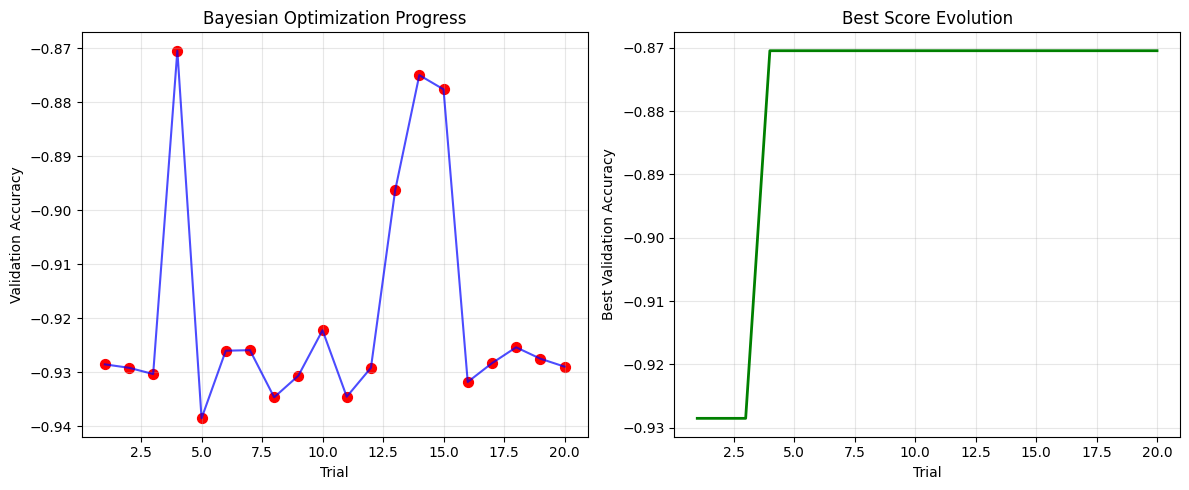


Hyperparameter Analysis:
----------------------------------------
embedding_dim: 67
lstm_units: 108
dropout_rate: 0.3482050932052023
learning_rate: 0.0030031754475310104
batch_size: 103
dense_units: 56
optimizer: adam
num_dense_layers: 2
l2_reg: 0.0015213743426653696


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot optimization progress
scores = [-result['val_accuracy'] for result in optimization_results]
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(scores) + 1), scores, 'b-', alpha=0.7)
plt.scatter(range(1, len(scores) + 1), scores, c='red', s=50)
plt.xlabel('Trial')
plt.ylabel('Validation Accuracy')
plt.title('Bayesian Optimization Progress')
plt.grid(True, alpha=0.3)

# Plot best score evolution
best_scores = []
best_so_far = -np.inf
for score in scores:
    if score > best_so_far:
        best_so_far = score
    best_scores.append(best_so_far)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(best_scores) + 1), best_scores, 'g-', linewidth=2)
plt.xlabel('Trial')
plt.ylabel('Best Validation Accuracy')
plt.title('Best Score Evolution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show hyperparameter importance
print("\nHyperparameter Analysis:")
print("-" * 40)
param_names = [dim.name for dim in search_space]
for i, (param, best_val) in enumerate(best_hyperparams.items()):
    print(f"{param}: {best_val}")



## STEP 5: TRAIN FINAL MODEL WITH BEST HYPERPARAMETERS

In [ ]:

print("TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS")

# Clear session
tf.keras.backend.clear_session()

# Convert numpy types to Python types
best_hyperparams = {k: int(v) if isinstance(v, np.integer) else float(v) if isinstance(v, np.floating) else v
                   for k, v in best_hyperparams.items()}

# Build final model with best hyperparameters
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')

embedded = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=best_hyperparams['embedding_dim'],
    input_length=MAX_SEQUENCE_LENGTH,
    name='embedding_layer'
)(text_input)

lstm_out = Bidirectional(
    LSTM(
        best_hyperparams['lstm_units'],
        return_sequences=True,
        name='lstm_layer'
    ),
    name='bidirectional_lstm'
)(embedded)

lstm_out = Dropout(best_hyperparams['dropout_rate'], name='lstm_dropout')(lstm_out)

# Attention mechanism
attention_weights = Dense(1, activation='tanh', name='attention_dense')(lstm_out)
attention_weights = tf.keras.layers.Flatten(name='attention_flatten')(attention_weights)
attention_weights = tf.keras.layers.Activation('softmax', name='attention_softmax')(attention_weights)
attention_weights = tf.keras.layers.RepeatVector(best_hyperparams['lstm_units'] * 2, name='attention_repeat')(attention_weights)
attention_weights = tf.keras.layers.Permute([2, 1], name='attention_permute')(attention_weights)

attended_lstm = tf.keras.layers.Multiply(name='attention_multiply')([lstm_out, attention_weights])
lstm_representation = AttentionSum(name='attention_sum')(attended_lstm)

# Content features
content_input = Input(shape=(6,), name='content_features')
content_dense = Dense(32, activation='relu', name='content_dense')(content_input)

# Combine features
combined = Concatenate(name='feature_concatenate')([lstm_representation, content_dense])

# Dense layers with best hyperparameters
x = combined
dense_units = best_hyperparams['dense_units']
for i in range(best_hyperparams['num_dense_layers']):
    x = Dense(dense_units, activation='relu',
             kernel_regularizer=l2(best_hyperparams['l2_reg']),
             name=f'dense_{i+1}')(x)
    x = Dropout(best_hyperparams['dropout_rate'], name=f'dropout_{i+1}')(x)
    dense_units = max(16, dense_units // 2)

# Output layer
output = Dense(1, activation='sigmoid', name='output_layer')(x)

# Create final model
final_model = Model(inputs=[text_input, content_input], outputs=output, name='optimized_fake_news_detector')

# Compile with best optimizer
if best_hyperparams['optimizer'] == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_hyperparams['learning_rate'])
else:
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_hyperparams['learning_rate'])

final_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Final model architecture:")
final_model.summary()

# Final training with more epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'final_optimized_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train final model with full epochs
print("Training final optimized model...")
final_history = final_model.fit(
    [X_train_padded, X_train_features], y_train,
    batch_size=best_hyperparams['batch_size'],
    epochs=15,  # Full training for final model
    validation_data=([X_val_padded, X_val_features], y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

print("\nFinal model training completed!")
print(f"Best hyperparameters used: {best_hyperparams}")

TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS
Final model architecture:


Model: "optimized_fake_news_detector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 500, 67)   │  1,340,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm  │ (None, 500, 216)  │    152,064 │ embedding_layer[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout        │ (None, 500, 216)  │          0 │ bidirectional_ls… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dense     │ (None, 500, 1)    │        217 │ lstm_dropout[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_flatten   │ (None, 500)       │          0 │ attention_dense[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_softmax   │ (None, 500)       │          0 │ attention_flatte… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_repeat    │ (None, 216, 500)  │          0 │ attention_softma… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_permute   │ (None, 500, 216)  │          0 │ attention_repeat… │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_multiply  │ (None, 500, 216)  │          0 │ lstm_dropout[0][… │
│ (Multiply)          │                   │            │ attention_permut… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ content_features    │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_sum       │ (None, 216)       │          0 │ attention_multip… │
│ (AttentionSum)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ content_dense       │ (None, 32)        │        224 │ content_features… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_concatenate │ (None, 248)       │          0 │ attention_sum[0]… │
│ (Concatenate)       │                   │            │ content_dense[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 56)        │     13,944 │ feature_concaten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 28)        │      1,596 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 28)        │          0 │ dense_2[0][0]   

 Total params: 1,508,074 (5.75 MB)

 Trainable params: 1,508,074 (5.75 MB)

 Non-trainable params: 0 (0.00 B)

Training final optimized model...
Epoch 1/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6370 - loss: 0.7162
Epoch 1: val_accuracy improved from -inf to 0.87584, saving model to final_optimized_model.h5


431/431 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - accuracy: 0.6372 - loss: 0.7159 - val_accuracy: 0.8758 - val_loss: 0.3225 - learning_rate: 0.0030
Epoch 2/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8948 - loss: 0.3096
Epoch 2: val_accuracy improved from 0.87584 to 0.91915, saving model to final_optimized_model.h5


431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.8948 - loss: 0.3095 - val_accuracy: 0.9192 - val_loss: 0.2348 - learning_rate: 0.0030
Epoch 3/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9459 - loss: 0.1789
Epoch 3: val_accuracy did not improve from 0.91915
431/431 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.9459 - loss: 0.1789 - val_accuracy: 0.9124 - val_loss: 0.3046 - learning_rate: 0.0030
Epoch 4/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9641 - loss: 0.1283
Epoch 4: val_accuracy improved from 0.91915 to 0.92935, saving model to final_optimized_model.h5


431/431 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.9641 - loss: 0.1283 - val_accuracy: 0.9294 - val_loss: 0.2077 - learning_rate: 0.0030
Epoch 5/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9746 - loss: 0.0953
Epoch 5: val_accuracy did not improve from 0.92935
431/431 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.9746 - loss: 0.0953 - val_accuracy: 0.9266 - val_loss: 0.2261 - learning_rate: 0.0030
Epoch 6/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9821 - loss: 0.0711
Epoch 6: val_accuracy did not improve from 0.92935
431/431 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.9822 - loss: 0.0711 - val_accuracy: 0.9267 - val_loss: 0.2789 - learning_rate: 0.0030
Epoch 7/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9896 - loss: 0.0509
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0015015876851975918.

Epoch 7: val_accuracy did not improve from 0.92935
431/431 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.9896 - loss: 0.0509 - v

431/431 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9907 - loss: 0.0422 - val_accuracy: 0.9323 - val_loss: 0.3341 - learning_rate: 0.0015
Epoch 9/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9972 - loss: 0.0232
Epoch 9: val_accuracy did not improve from 0.93230
431/431 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9972 - loss: 0.0232 - val_accuracy: 0.9308 - val_loss: 0.3569 - learning_rate: 0.0015
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.

Final model training completed!
Best hyperparameters used: {'embedding_dim': 67, 'lstm_units': 108, 'dropout_rate': 0.3482050932052023, 'learning_rate': 0.0030031754475310104, 'batch_size': 103, 'dense_units': 56, 'optimizer': 'adam', 'num_dense_layers': 2, 'l2_reg': 0.0015213743426653696}


## STEP 6: MODEL EVALUATION

In [ ]:
print("MODEL EVALUATION")

# Load the best model
final_model.load_weights('final_optimized_model.h5')


# Evaluate on validation set
print("Evaluating on validation set...")
val_loss, val_accuracy = final_model.evaluate([X_val_padded, X_val_features], y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy = final_model.evaluate([X_test_padded, X_test_features], y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
print("\nGenerating predictions...")
y_val_pred_proba = final_model.predict([X_val_padded, X_val_features], verbose=0)
y_test_pred_proba = final_model.predict([X_test_padded, X_test_features], verbose=0)

y_val_pred = (y_val_pred_proba > 0.5).astype(int).flatten()
y_test_pred = (y_test_pred_proba > 0.5).astype(int).flatten()

# Calculate AUC scores
val_auc = roc_auc_score(y_val, y_val_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\nAUC Scores:")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

MODEL EVALUATION
Evaluating on validation set...
Validation Loss: 0.3341
Validation Accuracy: 0.9323

Evaluating on test set...
Test Loss: 0.3478
Test Accuracy: 0.9301

Generating predictions...

AUC Scores:
Validation AUC: 0.9811
Test AUC: 0.9802


## STEP 7: DETAILED CLASSIFICATION REPORTS

In [ ]:
print("CLASSIFICATION REPORTS")
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred,
                          target_names=['Fake News', 'Real News'],
                          digits=4))

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred,
                          target_names=['Fake News', 'Real News'],
                          digits=4))


CLASSIFICATION REPORTS

Validation Set Classification Report:
              precision    recall  f1-score   support

   Fake News     0.9294    0.9199    0.9246      4293
   Real News     0.9346    0.9425    0.9386      5219

    accuracy                         0.9323      9512
   macro avg     0.9320    0.9312    0.9316      9512
weighted avg     0.9323    0.9323    0.9323      9512


Test Set Classification Report:
              precision    recall  f1-score   support

   Fake News     0.9323    0.9113    0.9217      4294
   Real News     0.9283    0.9456    0.9369      5218

    accuracy                         0.9301      9512
   macro avg     0.9303    0.9284    0.9293      9512
weighted avg     0.9301    0.9301    0.9300      9512



## STEP 8: CONFUSION MATRICES VISUALIZATION


Generating confusion matrices...


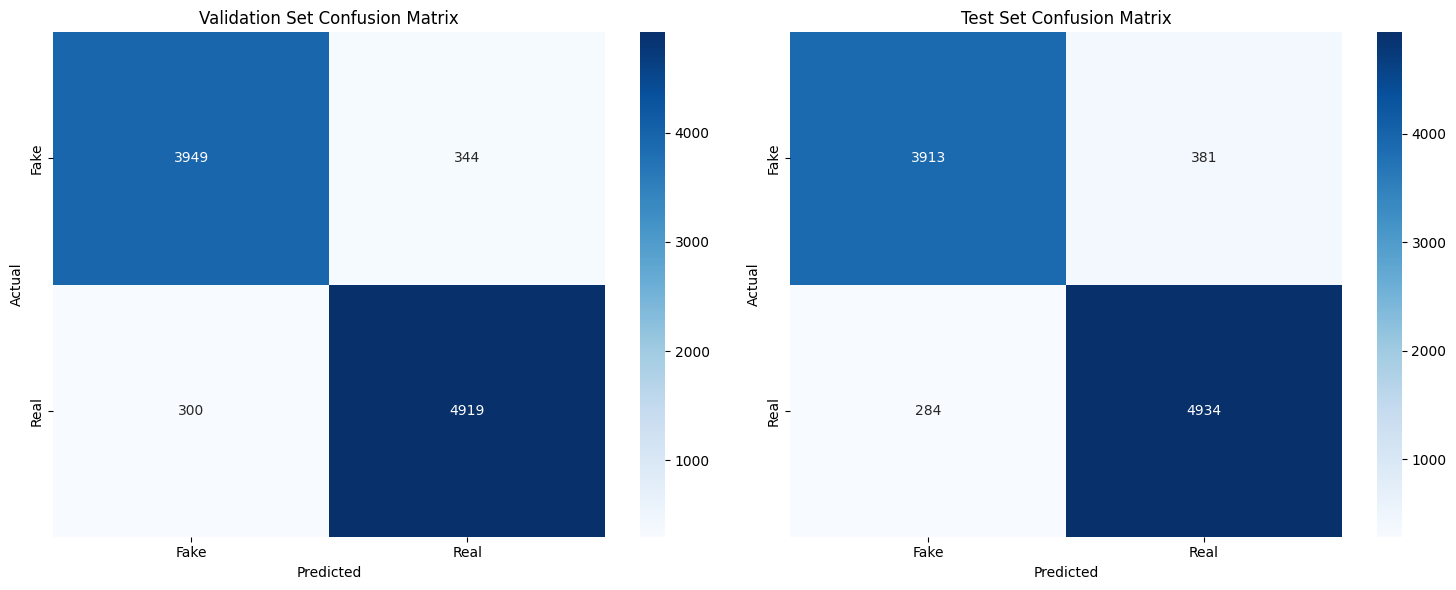


Detailed Metrics:
Metric       Validation   Test        
------------------------------------
accuracy     0.9323       0.9301      
precision    0.9346       0.9283      
recall       0.9425       0.9456      
f1_score     0.9386       0.9369      
specificity  0.9199       0.9113      


In [ ]:
print("\nGenerating confusion matrices...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Validation confusion matrix
val_cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
ax1.set_title('Validation Set Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Test confusion matrix
test_cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
ax2.set_title('Test Set Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Calculate and display detailed metrics
def calculate_metrics(cm):
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity
    }

val_metrics = calculate_metrics(val_cm)
test_metrics = calculate_metrics(test_cm)

print(f"\nDetailed Metrics:")
print(f"{'Metric':<12} {'Validation':<12} {'Test':<12}")
print("-" * 36)
for metric in val_metrics.keys():
    print(f"{metric:<12} {val_metrics[metric]:<12.4f} {test_metrics[metric]:<12.4f}")

## STEP 9: ROC CURVES


Generating ROC curves...


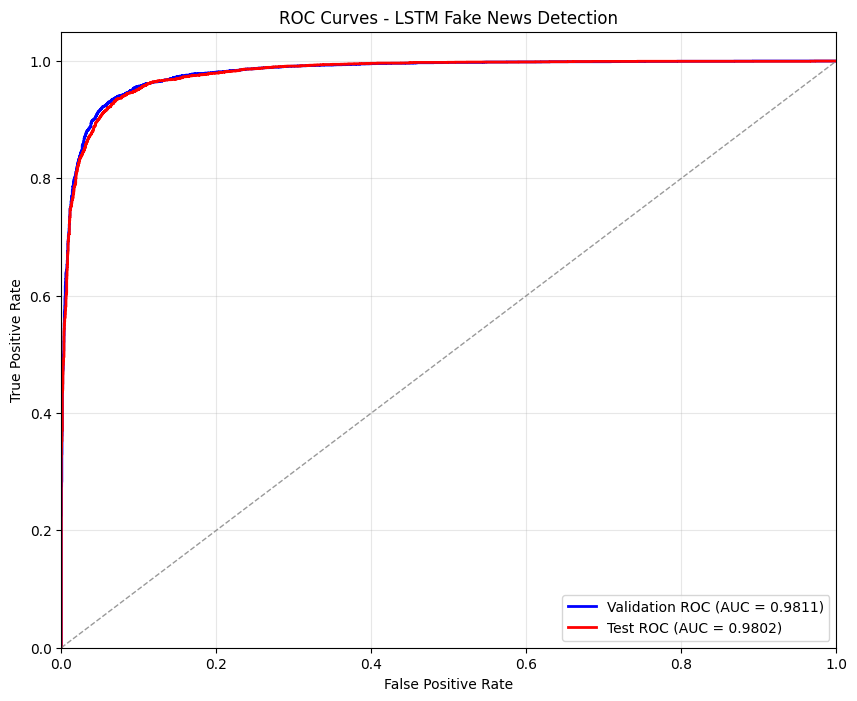

In [ ]:
print("\nGenerating ROC curves...")

# Calculate ROC curves
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_pred_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred_proba)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(val_fpr, val_tpr, color='blue', lw=2,
         label=f'Validation ROC (AUC = {val_auc:.4f})')
plt.plot(test_fpr, test_tpr, color='red', lw=2,
         label=f'Test ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.8)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - LSTM Fake News Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## STEP 10: PREDICTION EXAMPLES

In [ ]:
print("PREDICTION EXAMPLES")

# Function to make predictions on new text
def predict_news(text, title=""):
    """Bias-aware prediction function"""
    # Clean and combine text
    combined_text = clean_text(title + " " + text)

    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([combined_text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post'
    )

    # Extract content features
    content_features = extract_content_features([combined_text])

    # Predict
    prob = model.predict([padded, content_features], verbose=0)[0][0]
    prediction = "REAL" if prob > 0.5 else "FAKE"
    confidence = prob if prob > 0.5 else 1 - prob

    return prediction, confidence, prob

# Test with some examples from the test set
print("Testing predictions on sample articles from test set:")
print("-" * 60)

# Get some sample indices
sample_indices = np.random.choice(len(X_test), 5, replace=False)

for i, idx in enumerate(sample_indices):
    actual_label = "REAL" if y_test[idx] == 1 else "FAKE"
    predicted_prob = y_test_pred_proba[idx][0]
    predicted_label = "REAL" if predicted_prob > 0.5 else "FAKE"
    confidence = predicted_prob if predicted_prob > 0.5 else 1 - predicted_prob

    print(f"\nExample {i+1}:")
    print(f"Actual: {actual_label}")
    print(f"Predicted: {predicted_label} (Confidence: {confidence:.3f})")
    print(f"Raw Probability: {predicted_prob:.3f}")

    # Show first few words of the article
    sequence = X_test_padded[idx]
    words = []
    # Use tokenizer.index_word to convert token IDs back to words
    for token_id in sequence[:20]:  # First 20 tokens
        if token_id != 0:  # Skip padding
            word = tokenizer.index_word.get(token_id, '<UNK>')
            words.append(word)

    print(f"Article preview: {' '.join(words)}...")
    print("-" * 60)

PREDICTION EXAMPLES
Testing predictions on sample articles from test set:
------------------------------------------------------------

Example 1:
Actual: REAL
Predicted: REAL (Confidence: 1.000)
Raw Probability: 1.000
Article preview: hillary clinton turn private email publicly justice hillary clinton turn private email publicly justice hillary clinton prosecutor turn private email...
------------------------------------------------------------

Example 2:
Actual: REAL
Predicted: REAL (Confidence: 1.000)
Raw Probability: 1.000
Article preview: black life matter activist voice protest across britain time black life matter activist voice protest across britain time <OOV> black...
------------------------------------------------------------

Example 3:
Actual: REAL
Predicted: REAL (Confidence: 1.000)
Raw Probability: 1.000
Article preview: mateen employ hoping oil company mass satanic aim slogan mateen employ hoping oil company mass satanic aim slogan hoping struggle...
-----------------

## STEP 11: Precision-Recall Curve

298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


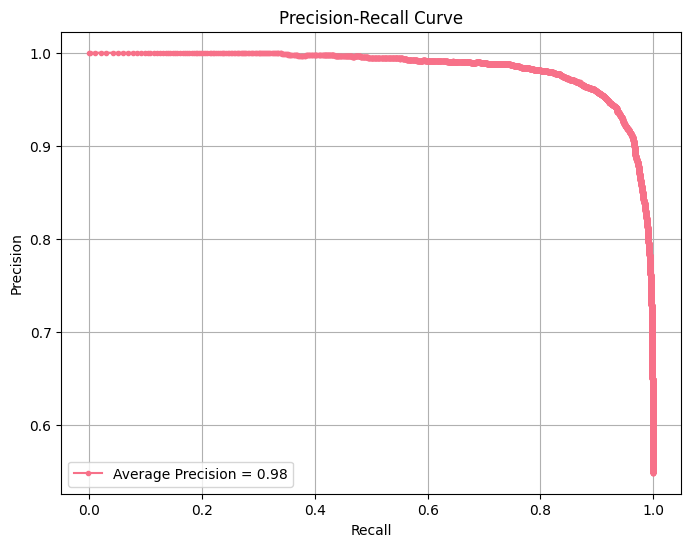

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predictions
y_pred_proba = final_model.predict([X_test_padded, X_test_features])

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate Average Precision (AP)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Average Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

##STEP 12: Error Analysis: Confusion Matrix with Percentages

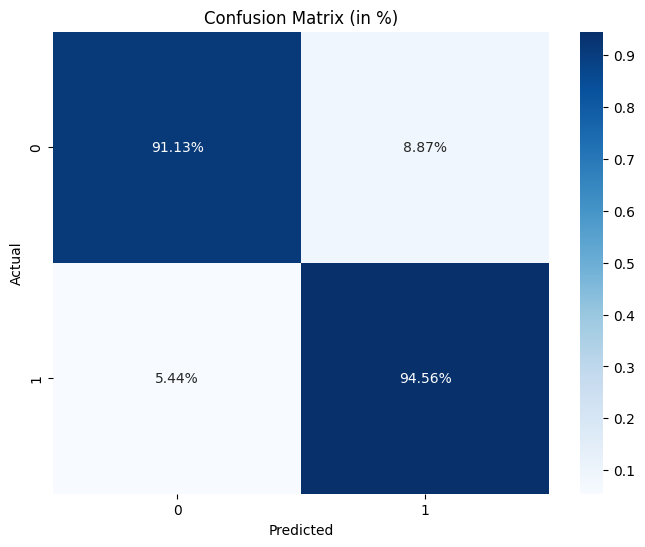

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = (y_pred_proba > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (in %)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Save the complete model after training is finished
# This saves architecture, weights, optimizer state, and compilation info
final_model.save('complete_fake_news_model.h5')

# Probability Calibration Analysis and Implementation for Fake News Detection

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, log_loss
import pickle
import tensorflow as tf
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## STEP 1: LOAD TRAINED MODEL AND DATA

In [ ]:
print("Loading trained model and test data...")

# Load your trained model
model = tf.keras.models.load_model('complete_fake_news_model.h5',
                                  custom_objects={'AttentionSum': AttentionSum})

# Load test data
X_test_padded = np.load('X_test_padded.npy')
X_test_features = np.load('X_test_features.npy')
y_test = np.load('y_test.npy')

# Load validation data for calibration
X_val_padded = np.load('X_val_padded.npy')
X_val_features = np.load('X_val_features.npy')
y_val = np.load('y_val.npy')

print(f"Test set size: {len(X_test_padded)}")
print(f"Validation set size: {len(X_val_padded)}")

Loading trained model and test data...
Test set size: 9512
Validation set size: 9512


## STEP 2: GENERATE PREDICTIONS

In [ ]:
print("\nGenerating predictions for calibration analysis...")

# Get predictions on validation set (for calibration)
y_val_proba = model.predict([X_val_padded, X_val_features], verbose=0).flatten()

# Get predictions on test set (for evaluation)
y_test_proba = model.predict([X_test_padded, X_test_features], verbose=0).flatten()

print(f"Validation predictions shape: {y_val_proba.shape}")
print(f"Test predictions shape: {y_test_proba.shape}")
print(f"Prediction range: [{y_val_proba.min():.3f}, {y_val_proba.max():.3f}]")


Generating predictions for calibration analysis...
Validation predictions shape: (9512,)
Test predictions shape: (9512,)
Prediction range: [0.000, 1.000]


## STEP 3: CALIBRATION ANALYSIS

In [ ]:
def analyze_calibration(y_true, y_proba, n_bins=10, title="Calibration Analysis"):
    """
    Comprehensive calibration analysis with multiple metrics
    """
    print(f"CALIBRATION ANALYSIS: {title}")

    # 1. Reliability diagram (calibration curve)
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_proba, n_bins=n_bins
    )

    # 2. Calculate calibration metrics
    brier_score = brier_score_loss(y_true, y_proba)
    log_loss_score = log_loss(y_true, y_proba)

    # 3. Expected Calibration Error (ECE)
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_proba > bin_lower) & (y_proba <= bin_upper)
        prop_in_bin = in_bin.mean()

        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_proba[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    # 4. Maximum Calibration Error (MCE)
    mce = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_proba > bin_lower) & (y_proba <= bin_upper)
        if in_bin.sum() > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_proba[in_bin].mean()
            mce = max(mce, np.abs(avg_confidence_in_bin - accuracy_in_bin))

    # 5. Statistical test for calibration
    # Hosmer-Lemeshow test approximation
    observed = np.bincount(np.digitize(y_proba, bin_boundaries) - 1, weights=y_true, minlength=n_bins)
    expected = np.bincount(np.digitize(y_proba, bin_boundaries) - 1, weights=y_proba, minlength=n_bins)

    # Avoid division by zero
    expected = np.where(expected == 0, 1e-10, expected)
    hl_stat = np.sum((observed - expected) ** 2 / expected)
    hl_p_value = 1 - stats.chi2.cdf(hl_stat, df=n_bins-2)

    # Print results
    print(f"Brier Score: {brier_score:.4f} (lower is better)")
    print(f"Log Loss: {log_loss_score:.4f} (lower is better)")
    print(f"Expected Calibration Error (ECE): {ece:.4f} (lower is better)")
    print(f"Maximum Calibration Error (MCE): {mce:.4f} (lower is better)")
    print(f"Hosmer-Lemeshow p-value: {hl_p_value:.4f} (>0.05 means well calibrated)")

    # Interpretation
    print(f"\nCALIBRATION ASSESSMENT:")
    if ece < 0.05:
        print("EXCELLENT calibration (ECE < 0.05)")
    elif ece < 0.10:
        print("GOOD calibration (ECE < 0.10)")
    elif ece < 0.15:
        print("MODERATE calibration (ECE < 0.15) - Consider calibration")
    else:
        print("POOR calibration (ECE >= 0.15) - Calibration HIGHLY recommended")

    if hl_p_value > 0.05:
        print("Statistical test: Well calibrated (p > 0.05)")
    else:
        print("Statistical test: Poorly calibrated (p <= 0.05)")

    return {
        'brier_score': brier_score,
        'log_loss': log_loss_score,
        'ece': ece,
        'mce': mce,
        'hl_p_value': hl_p_value,
        'fraction_of_positives': fraction_of_positives,
        'mean_predicted_value': mean_predicted_value
    }

# Analyze calibration on validation set
val_calibration = analyze_calibration(y_val, y_val_proba, title="Validation Set")

# Analyze calibration on test set
test_calibration = analyze_calibration(y_test, y_test_proba, title="Test Set")

CALIBRATION ANALYSIS: Validation Set
Brier Score: 0.0603 (lower is better)
Log Loss: 0.3266 (lower is better)
Expected Calibration Error (ECE): 0.0572 (lower is better)
Maximum Calibration Error (MCE): 0.3595 (lower is better)
Hosmer-Lemeshow p-value: 0.0000 (>0.05 means well calibrated)

CALIBRATION ASSESSMENT:
GOOD calibration (ECE < 0.10)
Statistical test: Poorly calibrated (p <= 0.05)
CALIBRATION ANALYSIS: Test Set
Brier Score: 0.0625 (lower is better)
Log Loss: 0.3403 (lower is better)
Expected Calibration Error (ECE): 0.0587 (lower is better)
Maximum Calibration Error (MCE): 0.3406 (lower is better)
Hosmer-Lemeshow p-value: 0.0000 (>0.05 means well calibrated)

CALIBRATION ASSESSMENT:
GOOD calibration (ECE < 0.10)
Statistical test: Poorly calibrated (p <= 0.05)


## STEP 4: VISUALIZATION


Generating calibration visualizations...


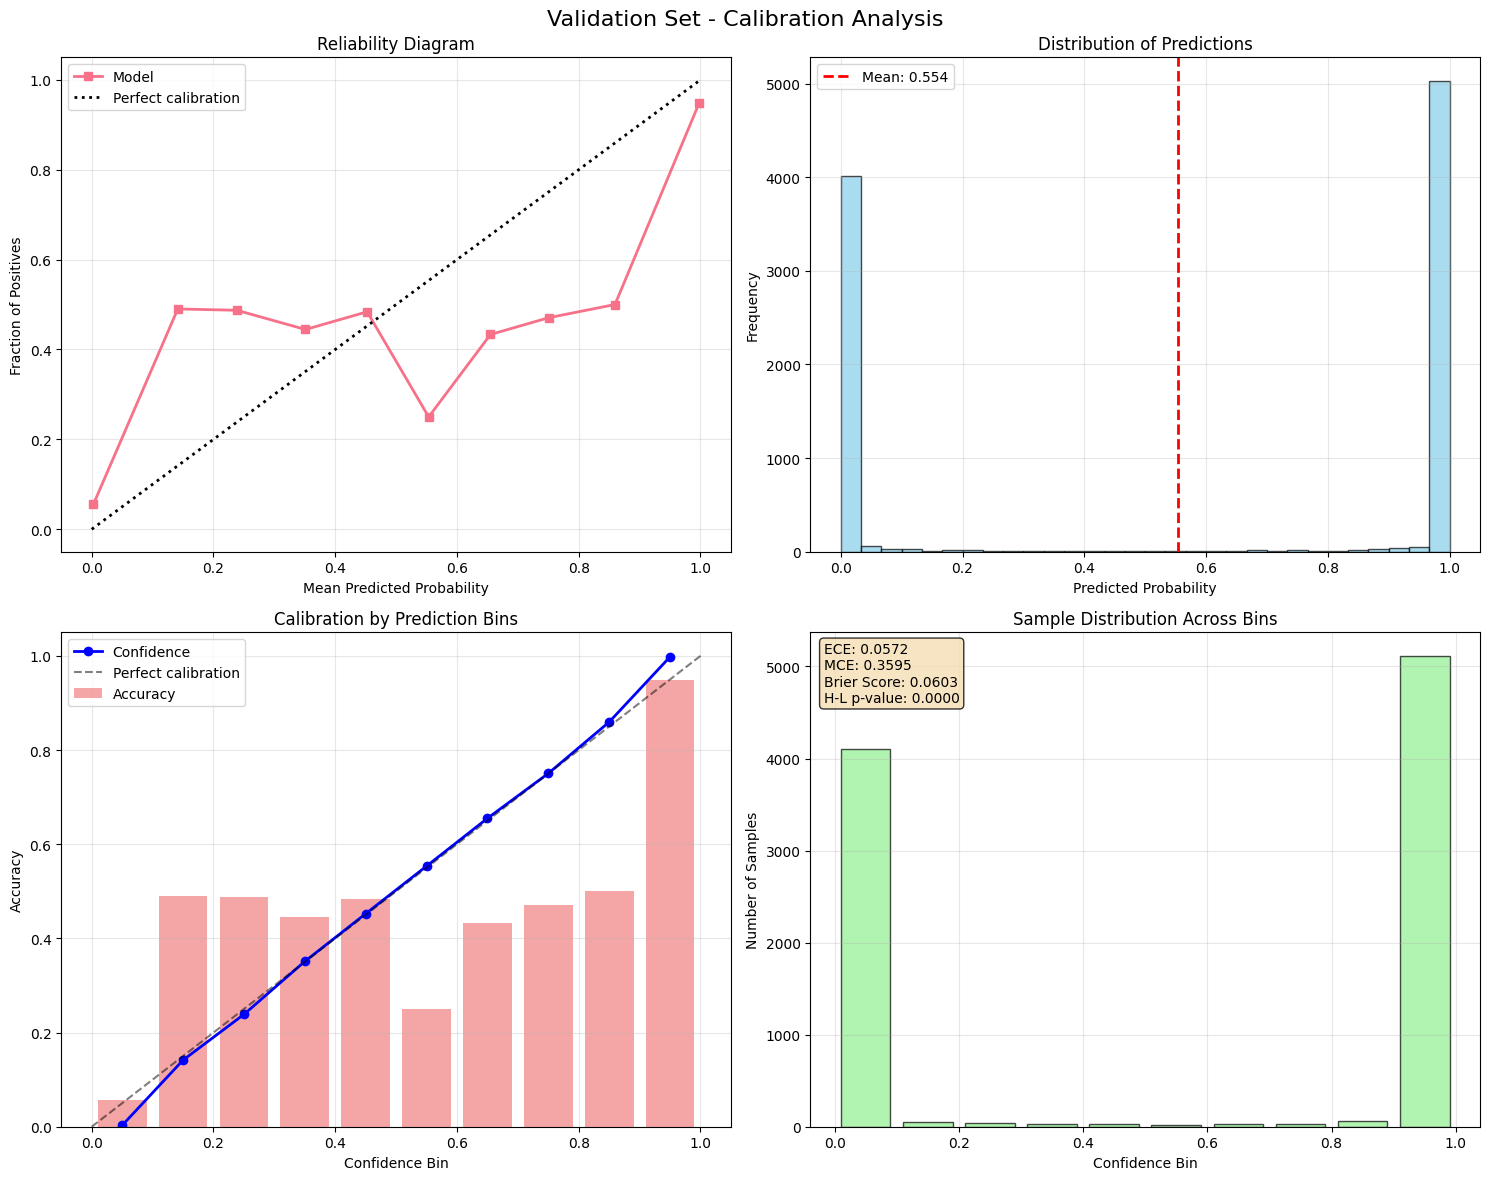

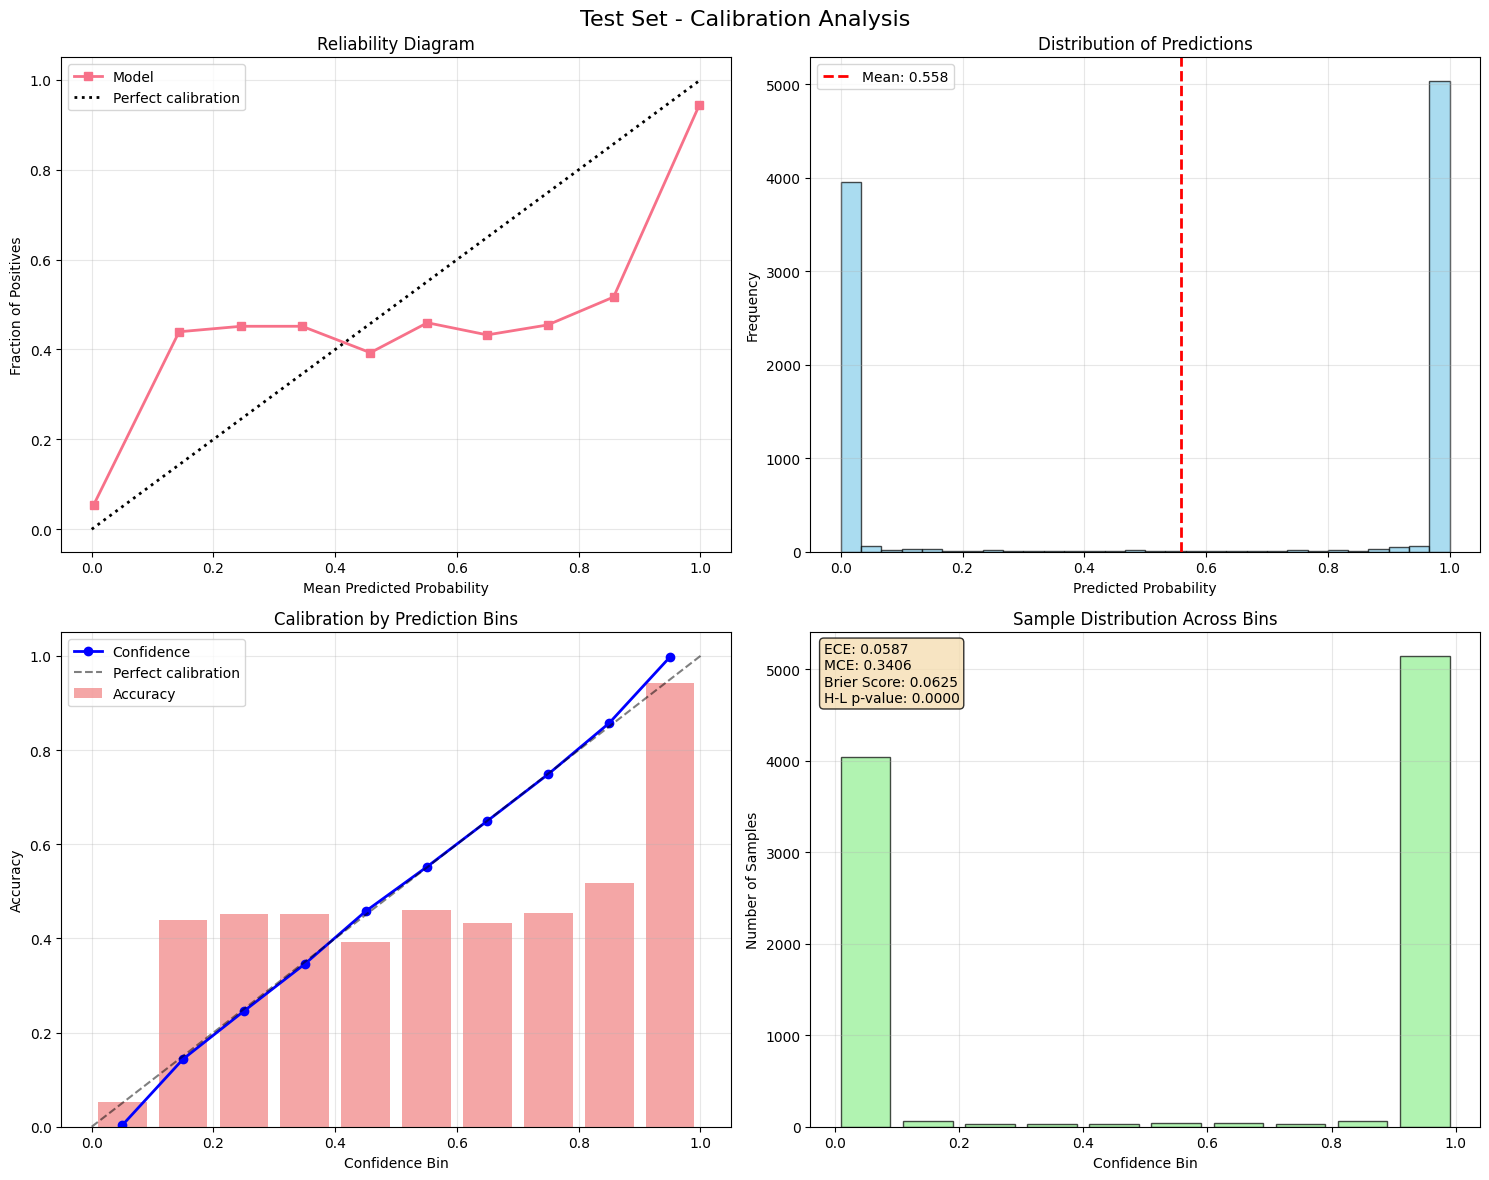

In [ ]:
def plot_calibration_analysis(y_true, y_proba, calibration_results, title="Calibration Analysis"):
    """
    Create comprehensive calibration plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{title} - Calibration Analysis', fontsize=16)

    # Reliability diagram
    ax1 = axes[0, 0]
    fraction_of_positives = calibration_results['fraction_of_positives']
    mean_predicted_value = calibration_results['mean_predicted_value']

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model", linewidth=2)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfect calibration", linewidth=2)
    ax1.set_xlabel("Mean Predicted Probability")
    ax1.set_ylabel("Fraction of Positives")
    ax1.set_title("Reliability Diagram")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Histogram of predictions
    ax2 = axes[0, 1]
    ax2.hist(y_proba, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(y_proba.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_proba.mean():.3f}')
    ax2.set_xlabel("Predicted Probability")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Distribution of Predictions")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Calibration by prediction bins
    ax3 = axes[1, 0]
    n_bins = 10
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accuracies = []
    confidences = []
    counts = []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_proba > bin_lower) & (y_proba <= bin_upper)
        if in_bin.sum() > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_proba[in_bin].mean()
            accuracies.append(accuracy_in_bin)
            confidences.append(avg_confidence_in_bin)
            counts.append(in_bin.sum())
        else:
            accuracies.append(0)
            confidences.append((bin_lower + bin_upper) / 2)
            counts.append(0)

    bin_centers = (bin_lowers + bin_uppers) / 2
    ax3.bar(bin_centers, accuracies, width=0.08, alpha=0.7, label='Accuracy', color='lightcoral')
    ax3.plot(bin_centers, confidences, 'bo-', label='Confidence', linewidth=2)
    ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
    ax3.set_xlabel("Confidence Bin")
    ax3.set_ylabel("Accuracy")
    ax3.set_title("Calibration by Prediction Bins")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Sample counts per bin
    ax4 = axes[1, 1]
    ax4.bar(bin_centers, counts, width=0.08, alpha=0.7, color='lightgreen', edgecolor='black')
    ax4.set_xlabel("Confidence Bin")
    ax4.set_ylabel("Number of Samples")
    ax4.set_title("Sample Distribution Across Bins")
    ax4.grid(True, alpha=0.3)

    # Add text box with metrics
    textstr = f'''ECE: {calibration_results['ece']:.4f}
MCE: {calibration_results['mce']:.4f}
Brier Score: {calibration_results['brier_score']:.4f}
H-L p-value: {calibration_results['hl_p_value']:.4f}'''

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax4.text(0.02, 0.98, textstr, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

# Plot calibration analysis
print("\nGenerating calibration visualizations...")
plot_calibration_analysis(y_val, y_val_proba, val_calibration, "Validation Set")
plot_calibration_analysis(y_test, y_test_proba, test_calibration, "Test Set")

## STEP 5: CALIBRATION METHODS

In [ ]:

print("IMPLEMENTING CALIBRATION METHODS")


# Method 1: Platt Scaling (Logistic Regression)
print("\n1. Platt Scaling (Logistic Regression)...")
platt_calibrator = LogisticRegression(solver='liblinear')
platt_calibrator.fit(y_val_proba.reshape(-1, 1), y_val)

# Method 2: Isotonic Regression
print("2. Isotonic Regression...")
isotonic_calibrator = IsotonicRegression(out_of_bounds='clip')
isotonic_calibrator.fit(y_val_proba, y_val)

# Method 3: Temperature Scaling (Neural Network specific)
print("3. Temperature Scaling...")

class TemperatureScaling:
    def __init__(self):
        # Initialize temperature to 1.0 (no change)
        self.temperature = 1.0
        self.epsilon = 1e-7 # Add epsilon to avoid log(0) or division by zero

    def _probabilities_to_logits(self, probabilities):
        """Converts probabilities to logits, handling edge cases."""
        # Clip probabilities to avoid log(0)
        clipped_probs = np.clip(probabilities, self.epsilon, 1 - self.epsilon)
        logits = np.log(clipped_probs / (1 - clipped_probs))
        return logits

    def _logits_to_probabilities(self, logits):
        """Converts logits to probabilities using the sigmoid function."""
        return 1 / (1 + np.exp(-logits))

    def fit(self, probabilities, labels):
        """
        Fits the temperature to the validation data by minimizing log loss.
        'probabilities' should be the output of the model's sigmoid layer.
        """
        from scipy.optimize import minimize

        # Convert initial probabilities to logits
        logits = self._probabilities_to_logits(probabilities)

        # Define the objective function to minimize (negative log-likelihood)
        def temperature_loss(temp):
            # Apply temperature to the original logits
            scaled_logits = logits / temp
            # Get new probabilities
            scaled_probs = self._logits_to_probabilities(scaled_logits)
            # Calculate loss
            return log_loss(labels, scaled_probs)

        # Find the optimal temperature by minimizing the loss function
        # We start with an initial temperature of 1.0 and search in a reasonable range
        result = minimize(temperature_loss, 1.0, method='L-BFGS-B', bounds=[(0.1, 10.0)])

        self.temperature = result.x[0]
        print(f"    Optimal temperature found: {self.temperature:.4f}")
        return self

    def predict_proba(self, probabilities):
        """
        Applies the learned temperature to new probabilities to calibrate them.
        """
        if self.temperature is None:
            raise RuntimeError("You must call 'fit' before 'predict_proba'.")

        # Convert input probabilities to logits
        logits = self._probabilities_to_logits(probabilities)
        # Scale logits with the optimal temperature
        scaled_logits = logits / self.temperature
        # Convert scaled logits back to calibrated probabilities
        calibrated_probs = self._logits_to_probabilities(scaled_logits)

        return calibrated_probs

# Convert probabilities to logits for temperature scaling
temp_calibrator = TemperatureScaling()
temp_calibrator.fit(y_val_proba, y_val)


IMPLEMENTING CALIBRATION METHODS

1. Platt Scaling (Logistic Regression)...
2. Isotonic Regression...
3. Temperature Scaling...
    Optimal temperature found: 2.6499


## STEP 6: EVALUATE CALIBRATION METHODS

In [ ]:
print("EVALUATING CALIBRATION METHODS")

# Apply calibration methods to test set
platt_test_proba = platt_calibrator.predict_proba(y_test_proba.reshape(-1, 1))[:, 1]
isotonic_test_proba = isotonic_calibrator.predict(y_test_proba)
temp_test_proba = temp_calibrator.predict_proba(y_test_proba)

# Evaluate each method
methods = {
    'Original': y_test_proba,
    'Platt Scaling': platt_test_proba,
    'Isotonic Regression': isotonic_test_proba,
    'Temperature Scaling': temp_test_proba
}

calibration_comparison = {}
for method_name, probas in methods.items():
    print(f"\n{method_name}:")
    calibration_comparison[method_name] = analyze_calibration(
        y_test, probas, title=method_name
    )



EVALUATING CALIBRATION METHODS

Original:
CALIBRATION ANALYSIS: Original
Brier Score: 0.0625 (lower is better)
Log Loss: 0.3403 (lower is better)
Expected Calibration Error (ECE): 0.0587 (lower is better)
Maximum Calibration Error (MCE): 0.3406 (lower is better)
Hosmer-Lemeshow p-value: 0.0000 (>0.05 means well calibrated)

CALIBRATION ASSESSMENT:
GOOD calibration (ECE < 0.10)
Statistical test: Poorly calibrated (p <= 0.05)

Platt Scaling:
CALIBRATION ANALYSIS: Platt Scaling
Brier Score: 0.0611 (lower is better)
Log Loss: 0.2341 (lower is better)
Expected Calibration Error (ECE): 0.0117 (lower is better)
Maximum Calibration Error (MCE): 0.3653 (lower is better)
Hosmer-Lemeshow p-value: 0.0000 (>0.05 means well calibrated)

CALIBRATION ASSESSMENT:
EXCELLENT calibration (ECE < 0.05)
Statistical test: Poorly calibrated (p <= 0.05)

Isotonic Regression:
CALIBRATION ANALYSIS: Isotonic Regression
Brier Score: 0.0519 (lower is better)
Log Loss: 0.1802 (lower is better)
Expected Calibration Er

## STEP 7: CHOOSE BEST CALIBRATION METHOD

In [ ]:

print("CALIBRATION METHOD COMPARISON")


# Compare methods
comparison_df = pd.DataFrame({
    method: {
        'ECE': results['ece'],
        'MCE': results['mce'],
        'Brier Score': results['brier_score'],
        'Log Loss': results['log_loss'],
        'H-L p-value': results['hl_p_value']
    }
    for method, results in calibration_comparison.items()
}).T

print("\nComparison of Calibration Methods:")
print(comparison_df.round(4))

# Find best method based on ECE
best_method = comparison_df['ECE'].idxmin()
print(f"\nBEST CALIBRATION METHOD: {best_method}")
print(f"   ECE: {comparison_df.loc[best_method, 'ECE']:.4f}")

CALIBRATION METHOD COMPARISON

Comparison of Calibration Methods:
                        ECE     MCE  Brier Score  Log Loss  H-L p-value
Original             0.0587  0.3406       0.0625    0.3403       0.0000
Platt Scaling        0.0117  0.3653       0.0611    0.2341       0.0000
Isotonic Regression  0.0108  0.0718       0.0519    0.1802       0.2412
Temperature Scaling  0.0225  0.1407       0.0538    0.1887       0.0000

BEST CALIBRATION METHOD: Isotonic Regression
   ECE: 0.0108


## STEP 8: SAVE CALIBRATION MODELS

In [ ]:
print("SAVING CALIBRATION MODELS")

# Save all calibration models
calibration_models = {
    'platt': platt_calibrator,
    'isotonic': isotonic_calibrator,
    'temperature': temp_calibrator,
    'best_method': best_method,
    'comparison_results': comparison_df.to_dict()
}

with open('calibration_models.pkl', 'wb') as f:
    pickle.dump(calibration_models, f)

print("Saved calibration models to 'calibration_models.pkl'")

SAVING CALIBRATION MODELS
Saved calibration models to 'calibration_models.pkl'


In [ ]:
import pickle
print("SAVING THE ISOTONIC REGRESSION CALIBRATOR FOR DEPLOYMENT")


# Define the filename for calibrator
filename = 'isotonic_calibrator.pkl'

# Save only the isotonic_calibrator object to the file
with open(filename, 'wb') as f:
    pickle.dump(isotonic_calibrator, f)

print(f"Isotonic Regression model successfully saved to '{filename}'")

SAVING THE ISOTONIC REGRESSION CALIBRATOR FOR DEPLOYMENT
Isotonic Regression model successfully saved to 'isotonic_calibrator.pkl'


## STEP 9: VISUALIZATION AFTER CALIBRATION

CALIBRATION ANALYSIS: Test Set - After Isotonic Regression
Brier Score: 0.0519 (lower is better)
Log Loss: 0.1802 (lower is better)
Expected Calibration Error (ECE): 0.0108 (lower is better)
Maximum Calibration Error (MCE): 0.0718 (lower is better)
Hosmer-Lemeshow p-value: 0.2412 (>0.05 means well calibrated)

CALIBRATION ASSESSMENT:
EXCELLENT calibration (ECE < 0.05)
Statistical test: Well calibrated (p > 0.05)


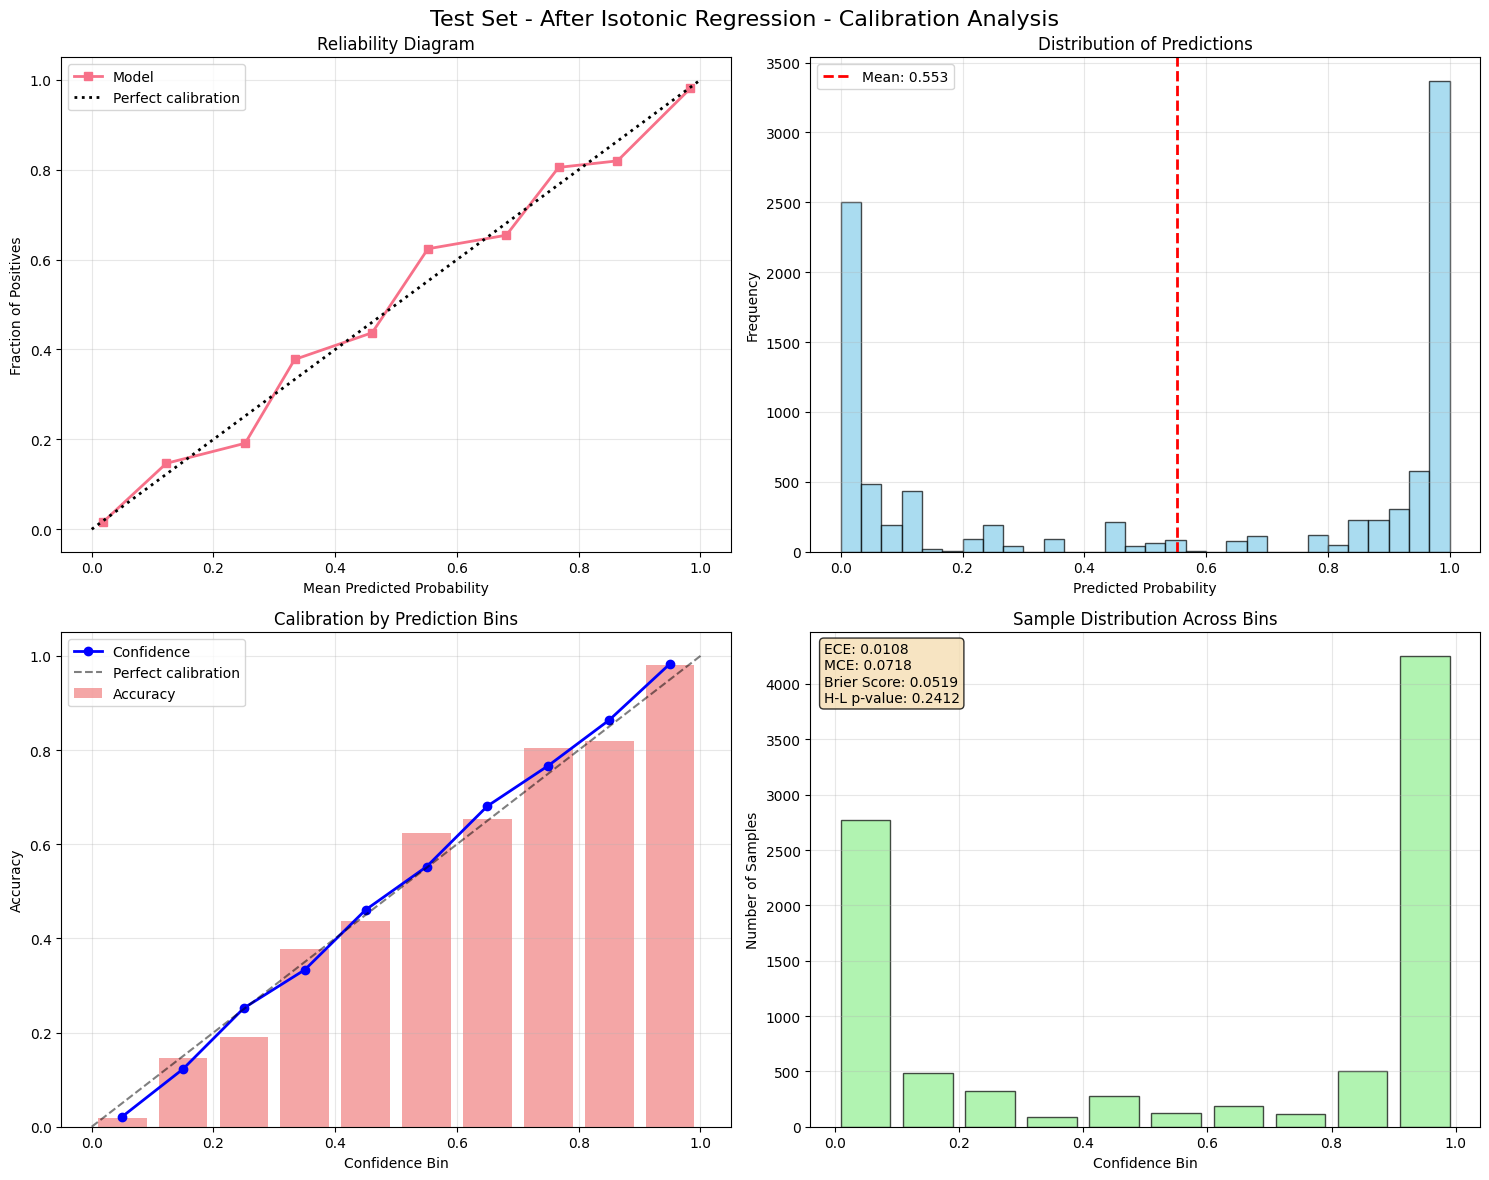

In [ ]:

calibrated_results = analyze_calibration(
    y_test,
    isotonic_test_proba,
    title="Test Set - After Isotonic Regression"
)

# Plot the NEW reliability diagram
plot_calibration_analysis(
    y_test,
    isotonic_test_proba,
    calibrated_results,
    "Test Set - After Isotonic Regression"
)

# LIME Analysis for Fake News Detection Model Bias Detection

This script analyzes potential biases in the LSTM fake news detection model


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# LIME imports
try:
    import lime
    import lime.lime_text
    from lime.lime_text import LimeTextExplainer
except ImportError:
    !pip install lime
    import lime
    import lime.lime_text
    from lime.lime_text import LimeTextExplainer

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=13235b15c7259ce96a9538ce87877a56bc527d0e4c5818a4bf62156605e6bae0
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


## STEP 1: LOAD MODEL AND PREPROCESSING ARTIFACTS

In [ ]:
print("Loading model and preprocessing artifacts...")

# Define the custom AttentionSum layer class so Keras can load the model
class AttentionSum(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionSum, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.reduce_sum(inputs, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

# Load the trained model with the custom object
try:
    # Ensure the correct path to your saved model
    model = load_model(
        'complete_fake_news_model.h5',
        custom_objects={'AttentionSum': AttentionSum}
    )
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure 'complete_fake_news_model.h5' is in the correct directory.")
    model = None

# Load tokenizer
try:
    with open('tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    print("Tokenizer loaded successfully")
except FileNotFoundError:
    print("Error: 'tokenizer.pkl' not found. Please ensure it is in the correct directory.")
    tokenizer = None

# Model parameters
MAX_SEQUENCE_LENGTH = 500

Loading model and preprocessing artifacts...
Model loaded successfully
Tokenizer loaded successfully


## STEP 2: PREPARE DATA FOR LIME ANALYSIS

In [ ]:
print("\nLoading original dataset and defining feature functions...")

# Load original dataset to get the raw text for explanation
try:
    df = pd.read_csv('WELFake_Dataset.csv')
    # Apply the same critical label correction for the LIME analysis.
    df['label'] = 1 - df['label']
    print("Original dataset loaded and labels corrected")
except FileNotFoundError:
    print("Could not load original dataset. Please ensure WELFake_Dataset.csv is available.")
    df = pd.DataFrame() # Create empty dataframe to avoid errors

# Helper function to extract content-based features, mirroring the training script
def extract_content_features(original_texts):
    features = []
    for text in original_texts:
        if pd.isna(text) or text == '':
            features.append([0, 0, 0, 0, 0, 0])
            continue

        words = text.split()
        num_chars = len(text)
        if num_chars == 0 or len(words) == 0:
            features.append([0, 0, 0, 0, 0, 0])
            continue

        exclamation_ratio = text.count('!') / num_chars
        question_ratio = text.count('?') / num_chars
        caps_ratio = sum(1 for c in text if c.isupper()) / num_chars
        avg_word_length = sum(len(word) for word in words) / len(words)
        sentence_count = max(1, len(re.split(r'[.!?]+', text)))
        avg_sentence_length = len(words) / sentence_count

        features.append([
            exclamation_ratio, question_ratio, caps_ratio,
            avg_word_length, sentence_count, avg_sentence_length
        ])
    return np.array(features)

# Apply minimal cleaning and combine title/text for LIME analysis
if not df.empty:
    df['title'] = df['title'].fillna('')
    df['text'] = df['text'].fillna('')
    # LIME works best on text that is as close to the original as possible.
    # We combine them for a complete view.
    df['explanation_text'] = df['title'] + ' ' + df['text']
    df = df.dropna(subset=['explanation_text'])
    df = df[df['explanation_text'].str.strip() != '']
    print(f"Preprocessed dataset for LIME: {len(df)} samples")


Loading original dataset and defining feature functions...
Original dataset loaded and labels corrected
Preprocessed dataset for LIME: 72134 samples


## STEP 3: CREATE STRATIFIED SAMPLE FOR LIME ANALYSIS

In [ ]:
print("\nCreating stratified sample for LIME analysis...")
if not df.empty:
    # Analyze a smaller, representative sample for efficiency
    sample_size = 200 # Using 200 samples for a robust but timely analysis
    df_sample = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), sample_size // 2), random_state=42))
    print(f"Created sample with {len(df_sample)} articles (Fake: {(df_sample['label']==0).sum()}, Real: {(df_sample['label']==1).sum()})")
else:
    df_sample = pd.DataFrame()
    print("Skipping sample creation as the dataset is empty.")


Creating stratified sample for LIME analysis...
Created sample with 200 articles (Fake: 100, Real: 100)


## STEP 4: CREATE PREDICTION FUNCTION FOR LIME

In [ ]:
def clean_text(text):
    if pd.isna(text) or text == '':
        return ''

    # Ensure text is a string and convert to lowercase
    text = str(text).lower()

    # Expand contractions
    contractions = {
        "won't": "will not", "can't": "cannot", "n't": " not", "'re": " are",
        "'ve": " have", "'ll": " will", "'d": " would", "'m": " am",
        "let's": "let us", "don't": "do not", "doesn't": "does not",
        "didn't": "did not", "isn't": "is not", "wasn't": "was not",
        "weren't": "were not", "haven't": "have not", "hasn't": "has not",
        "hadn't": "had not", "wouldn't": "would not",
        "shouldn't": "should not", "couldn't": "could not",
        "mustn't": "must not"
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)

    # Remove URLs, email addresses, and HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', '', text)

    # Remove source artifacts like "21st Century Wire" or "via Reuters"
    text = re.sub(r'(\d+)(st|nd|rd|th)\s*century\s*wire', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s*via\s+[\w\s.-]+', '', text)
    text = re.sub(r'pic.twitter.com/\w+', '', text)

    # Tokenize the text, which will separate words from punctuation
    tokens = word_tokenize(text)

    # Initialize lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Add specific words to the stop word list that might introduce bias
    additional_stopwords = {
        'reuters', 'breitbart', 'cnn', 'fox', 'bbc', 'nbc', 'abc', 'cbs',
        'associated', 'press', 'ap', 'bloomberg', 'wall', 'street', 'journal',
        'new', 'york', 'times', 'washington', 'post', 'guardian',
        'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
        'january', 'february', 'march', 'april', 'may', 'june', 'july',
        'august', 'september', 'october', 'november', 'december',
        'said', 'according', 'reported', 'also', 'u', 'image', 'images', 'video', 'videos',
        'file', 'files', 'tag', 'tags', 'loading', 'download', 'nyp', 'rasmussen', 'vice',
        'pic', 'via', 'twitter', 'news'
    }
    stop_words.update(additional_stopwords)

    cleaned_tokens = []
    for token in tokens:
        # Keep only alphabetic tokens
        if token.isalpha():
            lemma = lemmatizer.lemmatize(token)
            # Check length and stopwords AFTER lemmatizing
            if len(lemma) > 1 and lemma not in stop_words:
                cleaned_tokens.append(lemma)

    # Join tokens back into a single string.
    # The result will be a clean string of words, e.g., "article content"
    # This is the standard format for feeding into tokenizers.
    return " ".join(cleaned_tokens)


def predict_fn_for_lime(texts):

    # text sample generated by LIME. This ensures the model sees the
    # data in the format it was trained on.
    cleaned_texts = [clean_text(text) for text in texts]

    # Tokenize the now-cleaned texts using the trained tokenizer.
    sequences = tokenizer.texts_to_sequences(cleaned_texts)

    # Pad the sequences to the required length.
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    # Extract content-based features from the ORIGINAL perturbed texts,
    # as features like capitalization are lost after cleaning.
    content_features = extract_content_features(texts)

    # Make predictions using the model, which now receives both the
    # correctly preprocessed text and the content features.
    predictions = model.predict([padded_sequences, content_features], verbose=0)

    # Format the output for LIME: an array of [prob_fake, prob_real].
    prob_real = predictions.flatten()
    prob_fake = 1 - prob_real
    return np.column_stack([prob_fake, prob_real])

## STEP 5: SETUP LIME EXPLAINER

In [ ]:
if not df_sample.empty and model and tokenizer:
    print("\nSetting up LIME explainer and starting analysis (this may take several minutes)...")
    explainer = LimeTextExplainer(
        class_names=['Fake News', 'Real News'],
        random_state=42
    )

    # Storage for explanations and aggregated word importances
    explanations = []
    word_importance_fake = defaultdict(list)
    word_importance_real = defaultdict(list)

    analysis_samples = len(df_sample)
    for i, (idx, row) in enumerate(df_sample.iterrows()):
        print(f"\r  > Processing sample {i+1}/{analysis_samples}...", end="")
        text_instance = row['explanation_text']
        actual_label = row['label']

        try:
            # Generate the explanation for one article
            explanation = explainer.explain_instance(
                text_instance,
                predict_fn_for_lime,
                num_features=15,  # Show the top 15 words
                num_samples=1000  # Number of perturbations LIME generates
            )
            explanations.append({
                'text': text_instance,
                'actual_label': actual_label,
                'explanation': explanation
            })

            # Aggregate word importances across all samples
            # explanation.as_list() returns (word, weight) tuples
            for word, importance in explanation.as_list():
                # Words supporting "Real News" (class 1) have positive importance
                if importance > 0:
                    word_importance_real[word].append(importance)
                # Words supporting "Fake News" (class 0) have negative importance
                else:
                    word_importance_fake[word].append(abs(importance))

        except Exception as e:
            print(f"\nError processing sample at index {idx}: {str(e)}")
            continue

    print(f"\nLIME analysis complete. Processed {len(explanations)} samples.")
else:
    print("\nSkipping LIME analysis due to missing model, tokenizer, or data.")



Setting up LIME explainer and starting analysis (this may take several minutes)...
  > Processing sample 200/200...
LIME analysis complete. Processed 200 samples.


## STEP 6: ANALYZE AND VISUALIZE GLOBAL WORD IMPORTANCE


Analyzing global word importance patterns...
TOP WORDS INDICATING FAKE NEWS
Word                 Avg Importance       Frequency       Total Score    
world                0.1219               7               0.8531         
mins                 0.8118               1               0.8118         
However              0.1161               6               0.6965         
Donate               0.6365               1               0.6365         
Hillary              0.0396               14              0.5549         
UN                   0.1543               3               0.4629         
George               0.4256               1               0.4256         
Cover                0.4207               1               0.4207         
Wire                 0.0830               5               0.4148         
Wheeler              0.3929               1               0.3929         
inspect              0.3673               1               0.3673         
went                 0.0398        

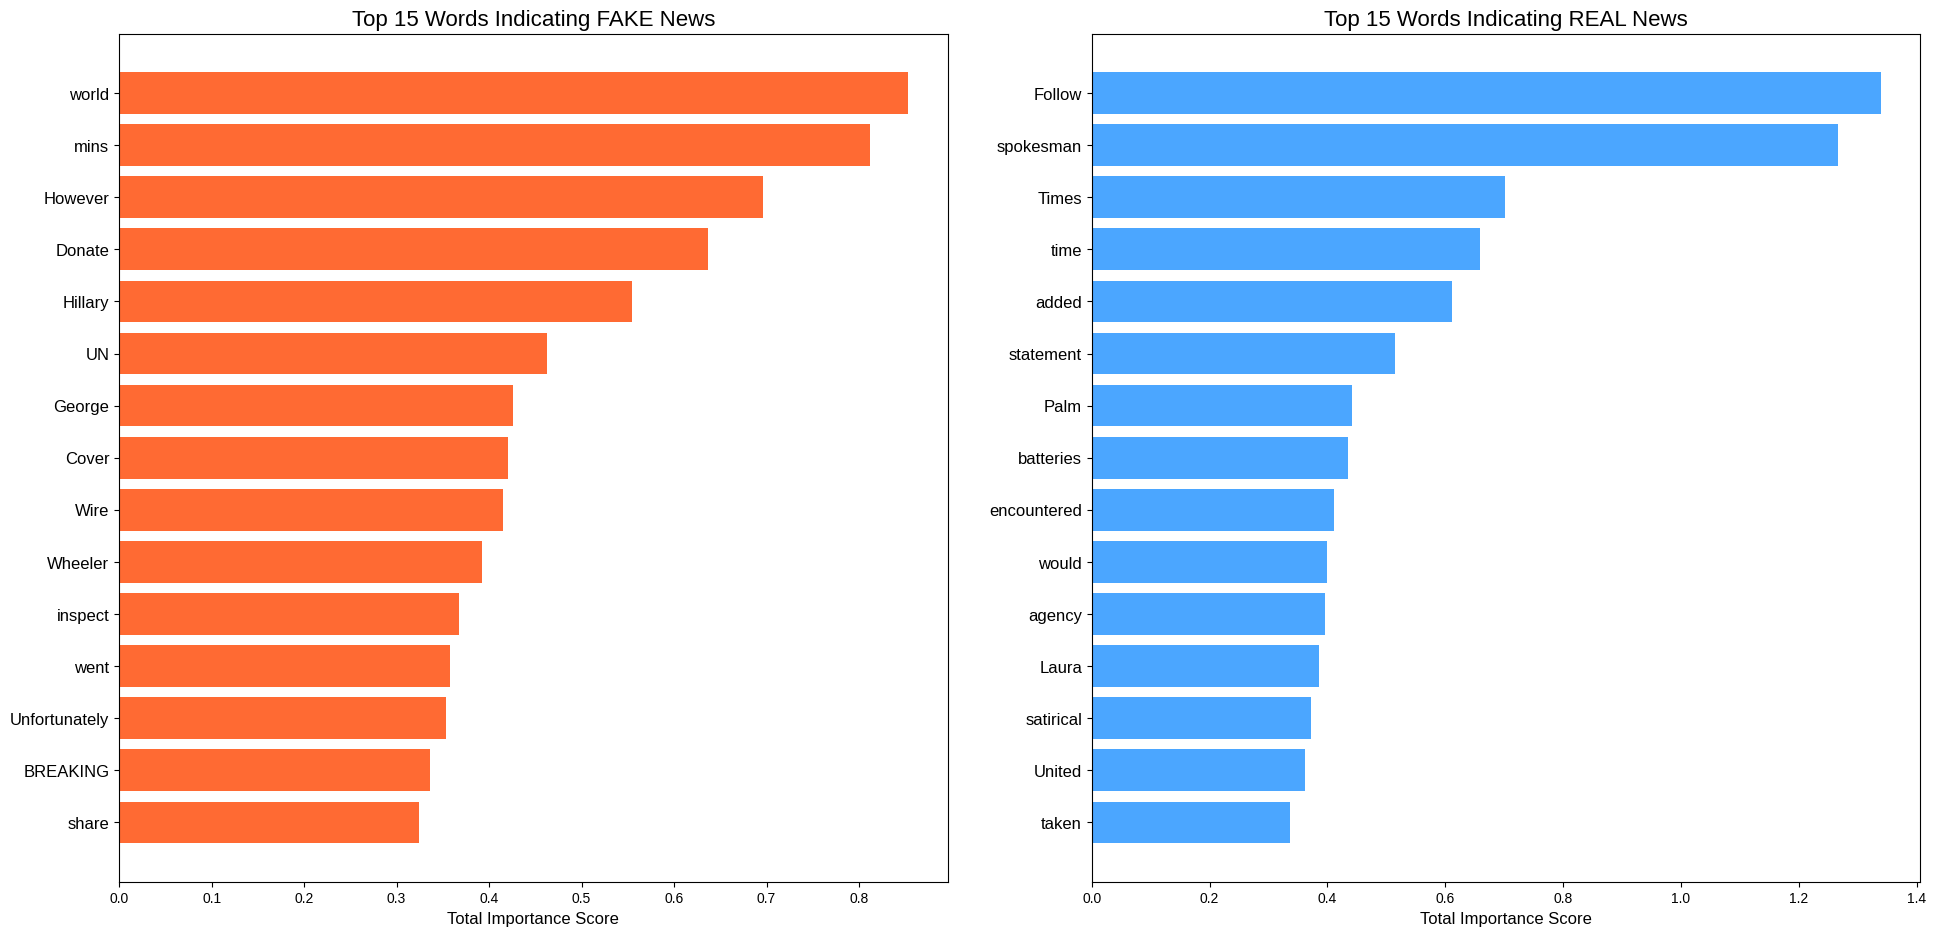

In [ ]:
if explanations:
    print("\nAnalyzing global word importance patterns...")

    # Calculate average importance and frequency for each word
    def calculate_scores(word_importance_dict):
        scores = {}
        for word, score_list in word_importance_dict.items():
            scores[word] = {
                'avg_importance': np.mean(score_list),
                'frequency': len(score_list),
                'total_importance': np.sum(score_list)
            }
        return scores

    fake_word_scores = calculate_scores(word_importance_fake)
    real_word_scores = calculate_scores(word_importance_real)

    # Sort words by total importance (a metric combining frequency and weight)
    top_fake_words = sorted(fake_word_scores.items(), key=lambda x: x[1]['total_importance'], reverse=True)
    top_real_words = sorted(real_word_scores.items(), key=lambda x: x[1]['total_importance'], reverse=True)

    # Display Top Words
    def display_top_words(title, word_list):
        print(f"TOP WORDS INDICATING {title}")
        print(f"{'Word':<20} {'Avg Importance':<20} {'Frequency':<15} {'Total Score':<15}")
        for word, stats in word_list[:15]: # Show top 15
            print(f"{word:<20} {stats['avg_importance']:<20.4f} {stats['frequency']:<15} {stats['total_importance']:<15.4f}")

    display_top_words("FAKE NEWS", top_fake_words)
    display_top_words("REAL NEWS", top_real_words)

    # Visualize Results
    print("\nGenerating visualizations...")
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    plt.style.use('seaborn-v0_8-whitegrid')

    def plot_word_importance(ax, word_list, title, color):
        words = [word for word, _ in word_list[:15]]
        scores = [stats['total_importance'] for _, stats in word_list[:15]]
        ax.barh(words, scores, color=color, alpha=0.8)
        ax.set_title(title, fontsize=16)
        ax.set_xlabel('Total Importance Score', fontsize=12)
        ax.invert_yaxis()
        ax.tick_params(axis='y', labelsize=12)

    plot_word_importance(axes[0], top_fake_words, 'Top 15 Words Indicating FAKE News', 'orangered')
    plot_word_importance(axes[1], top_real_words, 'Top 15 Words Indicating REAL News', 'dodgerblue')

    plt.tight_layout(pad=3.0)
    plt.show()


## STEP 7: SHOW EXAMPLE EXPLANATIONS

In [ ]:

    print("EXAMPLE LIME EXPLANATIONS")

    # Show a few example explanations
    for i, exp_data in enumerate(explanations[:3]): # Show first 3 examples
        explanation = exp_data['explanation']
        prediction_probs = explanation.predict_proba
        actual_label_str = "REAL" if exp_data['actual_label'] == 1 else "FAKE"

        print(f"\n--- Example {i+1} ---")
        print(f"ACTUAL LABEL: {actual_label_str}")
        print(f"Model Prediction: FAKE={prediction_probs[0]:.2f}, REAL={prediction_probs[1]:.2f}")
        print(f"\nText Preview: '{exp_data['text'][:250]}...'")
        print("\nLIME Explanation (Top words contributing to the prediction):")

        # Create a DataFrame for better display
        exp_list = explanation.as_list()
        exp_df = pd.DataFrame(exp_list, columns=['word', 'weight'])
        exp_df['contribution'] = np.where(exp_df['weight'] > 0, 'Supports REAL', 'Supports FAKE')
        exp_df['weight'] = abs(exp_df['weight'])
        print(exp_df.to_string(index=False))

    print("\n\nLIME analysis complete! Check the visualizations and tables for detailed insights.")

EXAMPLE LIME EXPLANATIONS

--- Example 1 ---
ACTUAL LABEL: FAKE
Model Prediction: FAKE=1.00, REAL=0.00

Text Preview: 'Why Trump Won; Why Clinton Lost   WashingtonsBlog 
By Robert Parry, the investigative reporter who many of the Iran-Contra stories for The Associated Press and Newsweek in the 1980s. Originally published at Parry’s Consortium News (republished with p...'

LIME Explanation (Top words contributing to the prediction):
        word   weight  contribution
     coupled 0.002871 Supports FAKE
       Libya 0.002814 Supports FAKE
        Cold 0.002555 Supports FAKE
        some 0.002502 Supports FAKE
  deregulate 0.002430 Supports FAKE
    February 0.001928 Supports FAKE
inarticulate 0.001794 Supports REAL
Alternatives 0.001156 Supports REAL
    speaking 0.001073 Supports REAL
     wealthy 0.000614 Supports REAL
        left 0.000604 Supports FAKE
          al 0.000471 Supports REAL
     torture 0.000255 Supports REAL
    reporter 0.000167 Supports FAKE
          It 0.000003 Su